# Configuracion del entorno

In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev==2.3.29
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path

def plot_label_counts(dls):
    # Inicializar listas para etiquetas de training (originales y destiladas)
    train_original_labels = []
    train_distilled_labels = []

    # Recorrer cada ejemplo en el dataset de training
    for i in range(len(dls.train_ds)):
        label = int(dls.train_ds[i][1])
        # Obtener la ruta del archivo y extraer el nombre
        path = Path(dls.train_ds.items[i])
        filename = path.name.lower()  # convertir a minúsculas para evitar problemas con mayúsculas

        # Clasificar: si el nombre comienza con 'distilled', es destilado; de lo contrario, es original.
        if filename.startswith("distilled"):
            train_distilled_labels.append(label)
        else:
            train_original_labels.append(label)

    # Para validación, todas las imágenes se consideran originales
    valid_labels = [int(dls.valid_ds[i][1]) for i in range(len(dls.valid_ds))]

    # Contar el número de ejemplos por etiqueta en cada grupo
    train_orig_counts = Counter(train_original_labels)
    train_dist_counts = Counter(train_distilled_labels)
    valid_counts = Counter(valid_labels)

    # Obtenemos el vocabulario (lista de nombres de clases) y el número de clases:
    vocab = dls.vocab
    n_classes = len(vocab)

    # Crear listas de conteos para cada clase (asumiendo índices de 0 a n_classes-1)
    orig_data = [train_orig_counts[i] for i in range(n_classes)]
    dist_data = [train_dist_counts[i] for i in range(n_classes)]
    valid_data = [valid_counts[i] for i in range(n_classes)]

    # Configurar el gráfico de barras agrupadas:
    x = np.arange(n_classes)
    width = 0.25  # ancho de cada barra, para acomodar tres barras por etiqueta

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width, orig_data, width, label='Train Original', color='blue')
    ax.bar(x, dist_data, width, label='Train Distilled', color='red')
    ax.bar(x + width, valid_data, width, label='Valid', color='yellow')

    ax.set_ylabel('Número de elementos')
    ax.set_xticks(x)
    ax.set_xticklabels(vocab)
    ax.legend()

    plt.show()


# Apartado 1

Obtenemos los datos

In [4]:
os.environ["FASTAI_HOME"] = str(Path('/content/dataset'))

try:
  path = untar_data(URLs.MNIST)
except Exception as e:
  print(f"Error al descargar el dataset: {e}")


Lo ordenamos correctamente con los path

In [5]:
# Definir rutas para la organización
base_path = Path('/content/dataset')
original_path = base_path / "original"

original_path.mkdir(parents=True, exist_ok=True)

dest_original = original_path / path.name
if not dest_original.exists():
    shutil.move(str(path), str(dest_original))
    print(f"Dataset movido a: {dest_original}")
else:
    print("El dataset ya se encuentra en la carpeta original.")

Dataset movido a: /content/dataset/original/mnist_png


Montamos el drive para que tenga acceso

In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## LENET

Creamos el datablock para lenet

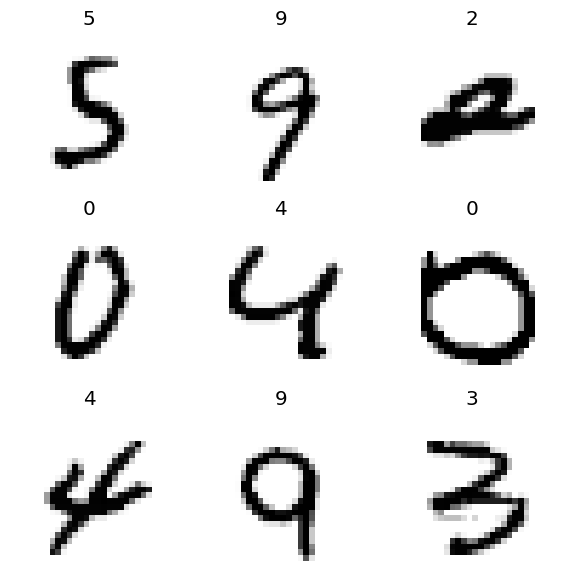

In [ ]:
# Crear los DataLoaders
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls = blocks.dataloaders(original_path/'mnist_png'/'training', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 48000
Número total de imágenes en validación: 12000

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


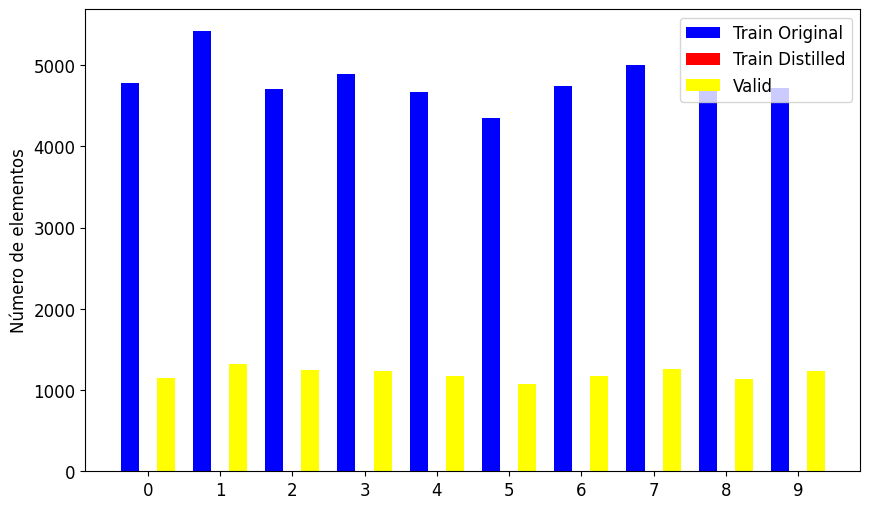

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Aplanar la salida
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

learn.summary()

LeNet (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 24 x 24    
Conv2d                                    156        True      
____________________________________________________________________________
                     64 x 16 x 8 x 8     
Conv2d                                    2416       True      
____________________________________________________________________________
                     64 x 16 x 4 x 4     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 120            
Linear                                    30840      True      
____________________________________________________________________________
                     64 x 84             
Linear                                    10164      True      
____________________________________________________________

In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 9: early stopping

Tiempo de entrenamiento: 989.56 segundos


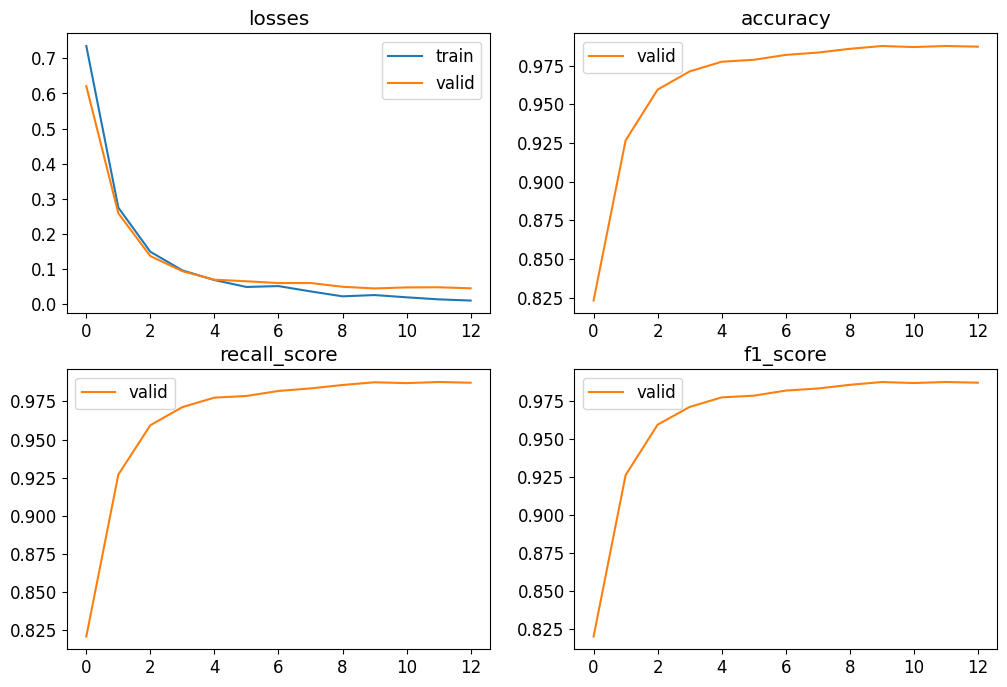

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0443
Accuracy: 0.9872
Recall: 0.9873
F1-Score: 0.9872


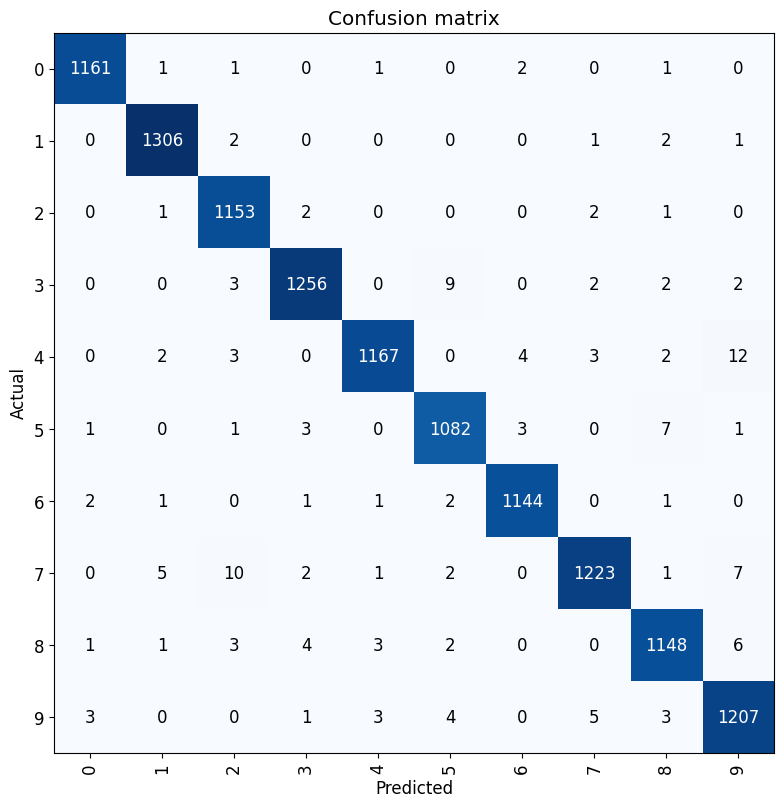

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

## Resnet

In [ ]:
original_path = Path("/content/dataset/original/mnist_png")

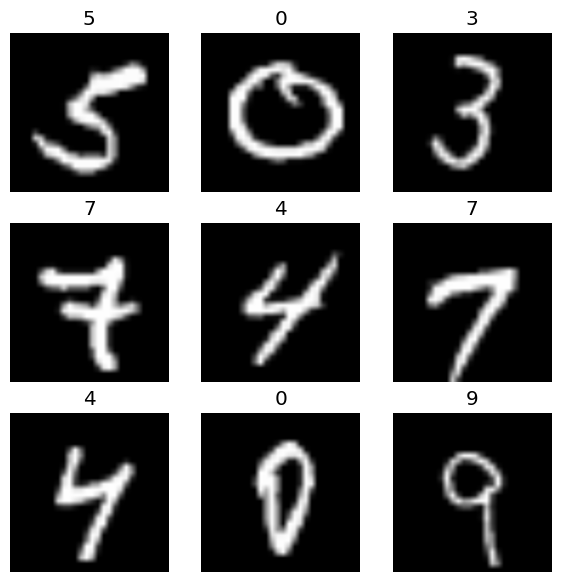

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

dls = dblock.dataloaders(original_path/'training', bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Crear el learner con resnet18
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Entrenar el modelo
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 10: early stopping

Tiempo de entrenamiento: 2818.79 segundos


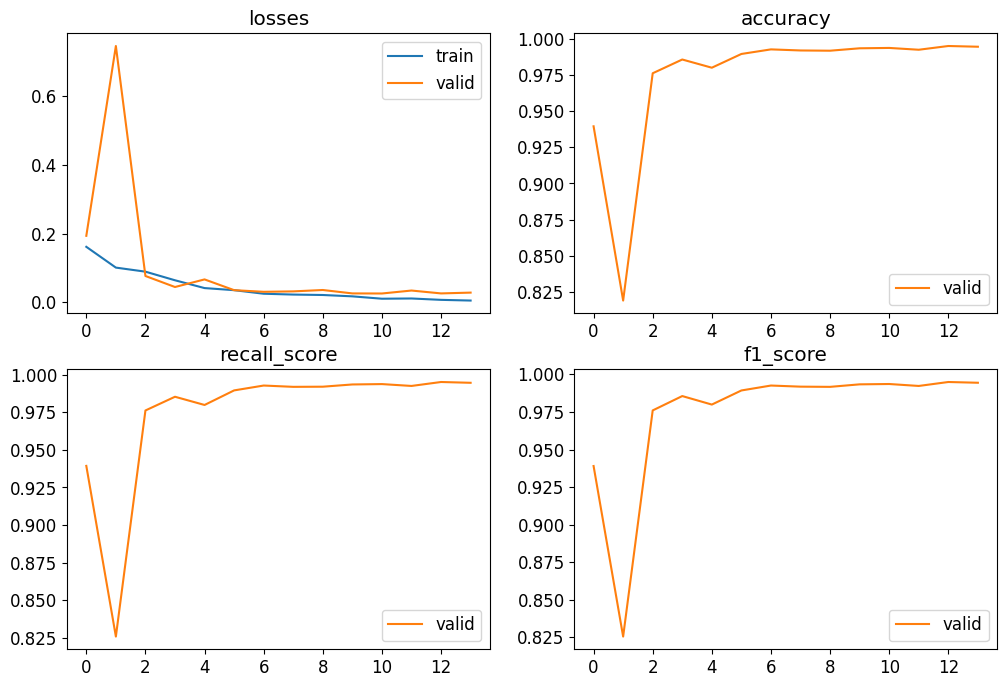

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0281
Accuracy: 0.9945
Recall: 0.9946
F1-Score: 0.9945


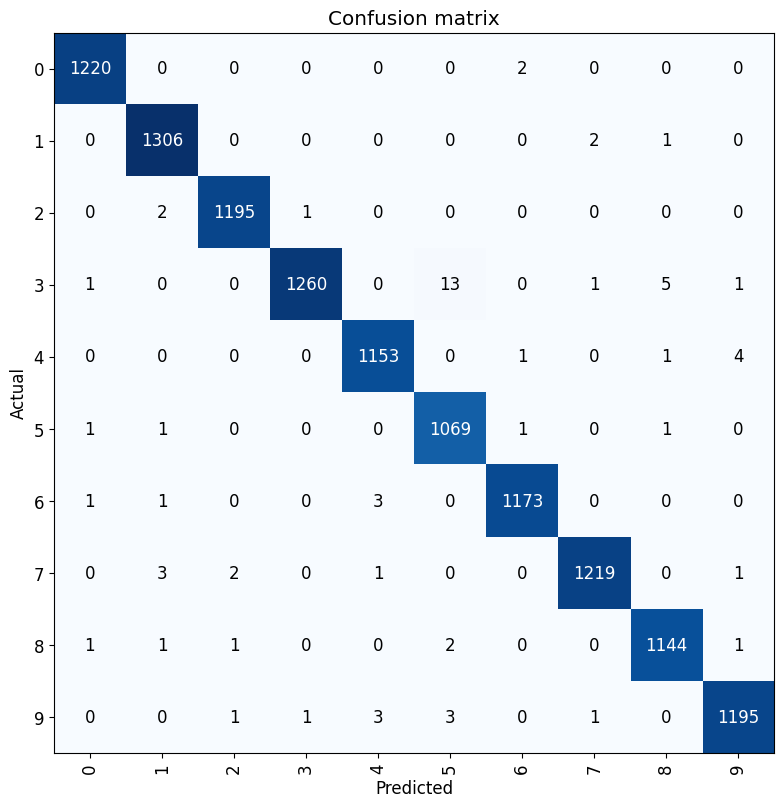

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

# Apartado 2

## Destilacion de datos

In [ ]:
original_path = base_path / "original"

mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

In [9]:
import random
import shutil
from pathlib import Path
import numpy as np
from PIL import Image

def media_arit(image_paths):
    avg_image = None
    count = 0
    # Sumar todas las imágenes (convertidas a array NumPy)
    for img_path in image_paths:
        with Image.open(img_path) as img:
            np_img = np.array(img, dtype=np.float32)
            if avg_image is None:
                avg_image = np_img
            else:
                avg_image += np_img
            count += 1
    # Calcular la media y convertir a uint8
    avg_image /= count
    avg_image = np.clip(avg_image, 0, 255).astype(np.uint8)
    return Image.fromarray(avg_image, mode='L')


In [10]:
def create_partial_distilled(src_path, dst_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=1, mix_function=media_arit):
    """
    Crea un nuevo dataset a partir de src_path con la siguiente estrategia:

      - Se divide en 80% training y 20% validación (valid_ratio).
      - En el conjunto de training:
          * El 80% de las imágenes se procesan mediante destilación usando mix_function.
          * El 20% restante se copia sin modificar.
      - En el conjunto de validación se copian las imágenes sin modificaciones.

    Parámetros:
      src_path: Ruta a la carpeta original, que debe tener subcarpetas para cada clase.
      dst_path: Ruta destino para el nuevo dataset.
      valid_ratio: Proporción de imágenes para validación (ej. 0.2 para 20%).
      distilled_portion: Proporción de imágenes dentro del training que serán destiladas (ej. 0.8 para 80%).
      group_fraction:
          * Si es 1, se mezclan todas las imágenes del subconjunto de destilación en una sola imagen.
          * Si es un valor entre 0 y 1, se agrupan en bloques cuyo tamaño es group_size = int(len(distilled_images) * group_fraction).
          * Si es 0, se procesa cada imagen individualmente (aunque normalmente querrás usar 1 o un valor intermedio).
      mix_function: Función que recibe una lista de rutas de imágenes y devuelve una imagen destilada.
    """
    src_path = Path(src_path)
    dst_path = Path(dst_path)

    # Eliminar dst_path si ya existe
    if dst_path.exists():
        shutil.rmtree(dst_path)
    dst_path.mkdir(parents=True, exist_ok=True)

    # Crear directorios para training y validación
    train_dst = dst_path / "training"
    valid_dst = dst_path / "valid"
    train_dst.mkdir(parents=True, exist_ok=True)
    valid_dst.mkdir(parents=True, exist_ok=True)

    # Procesar cada subcarpeta (clase) en src_path
    for class_dir in src_path.iterdir():
        if not class_dir.is_dir():
            continue

        images = list(class_dir.glob('*.*'))
        if not images:
            continue

        # Barajar y separar en training y validación
        random.shuffle(images)
        total = len(images)
        n_valid = int(total * valid_ratio)
        n_train = total - n_valid

        train_images = images[:n_train]
        valid_images = images[n_train:]

        # Dentro de training, separar el 80% para destilación y el 20% para copiar sin modificar
        n_train_distilled = int(n_train * distilled_portion)
        n_train_original = n_train - n_train_distilled

        distilled_images = train_images[:n_train_distilled]
        original_train_images = train_images[n_train_distilled:]

        # Crear subdirectorios para la clase en training y validación
        new_train_class_dir = train_dst / class_dir.name
        new_train_class_dir.mkdir(parents=True, exist_ok=True)
        new_valid_class_dir = valid_dst / class_dir.name
        new_valid_class_dir.mkdir(parents=True, exist_ok=True)

        # Procesar las imágenes para destilación (80% del conjunto de training)
        if group_fraction == 0:
            # Procesar cada imagen individualmente (aunque esto normalmente no es lo esperado)
            for img_path in distilled_images:
                distilled_img = mix_function([img_path])
                # Se guarda con el mismo nombre original
                new_file = new_train_class_dir / img_path.name
                distilled_img.save(new_file)
        elif group_fraction == 1:
            # Mezclar todas las imágenes del subconjunto en una sola imagen destilada
            distilled_img = mix_function(distilled_images)
            distilled_filename = new_train_class_dir / "distilled.jpg"
            distilled_img.save(distilled_filename)
        else:
            # Agrupar las imágenes en bloques
            group_size = max(1, int(len(distilled_images) * group_fraction))
            group_count = 0
            for i in range(0, len(distilled_images), group_size):
                group = distilled_images[i:i + group_size]
                distilled_img = mix_function(group)
                distilled_filename = new_train_class_dir / f"distilled_{group_count}.jpg"
                distilled_img.save(distilled_filename)
                group_count += 1

        # Copiar las imágenes originales (20% de training) sin modificar
        for img_path in original_train_images:
            shutil.copy(img_path, new_train_class_dir)

        # En validación se copian todas las imágenes sin procesar
        for img_path in valid_images:
            shutil.copy(img_path, new_valid_class_dir)


In [ ]:
create_partial_distilled(original_path/'mnist_png'/'training', mnist_001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.01, mix_function=media_arit)


In [ ]:
mnist_005_path = base_path / "distilled_005"
mnist_005_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_005_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.05, mix_function=media_arit)

In [ ]:
mnist_0001_path = base_path / "distilled_0001"
mnist_0001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_0001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.001, mix_function=media_arit)

Total de ejemplos: 60,000

División Train/Test: 80% (Train) - 20% (Test):
- Cantidad en Train: 80% de 60,000 = 48,000 ejemplos
- Cantidad en Test: 20% de 60,000 = 12,000 ejemplos

Dentro de Train:
- 80% se destilan → 80% de 48,000 = 38,400 que se destilan al x%
- 20% se mantienen intactos → 20% de 48,000 = 9,600 ejemplos originales


Suponiendo que x = 1%:
- tenemos 100 + 9,600 = 9,700 aproximadamente


## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

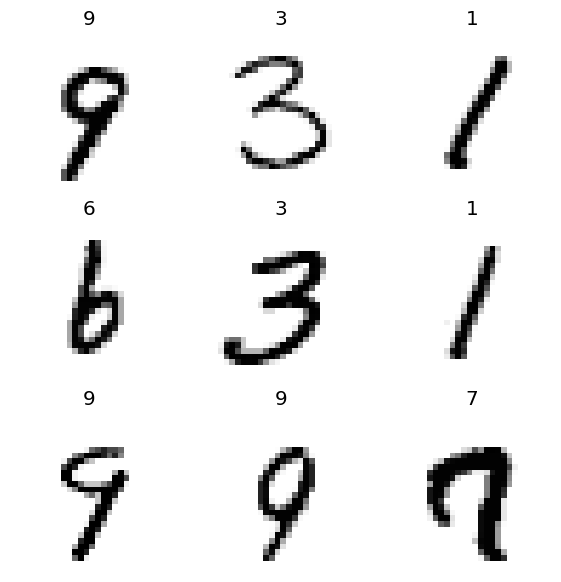

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 10622
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


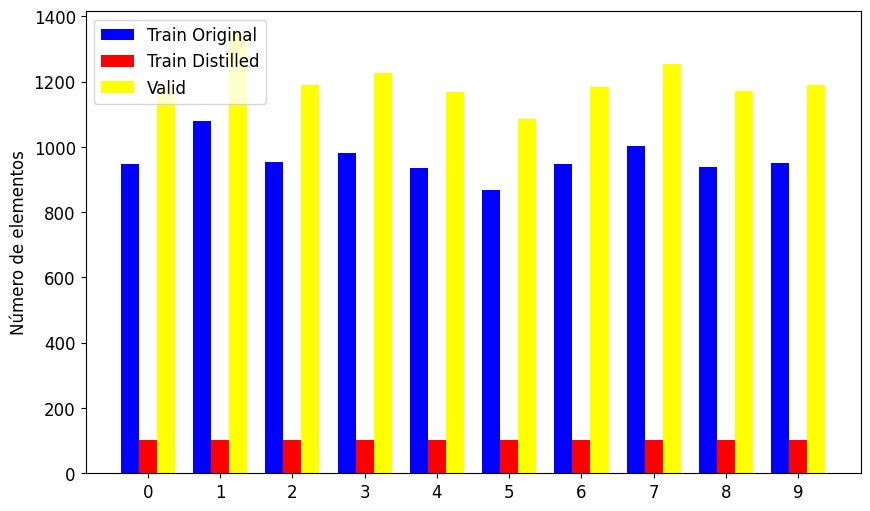

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 14: early stopping

Tiempo de entrenamiento: 515.66 segundos


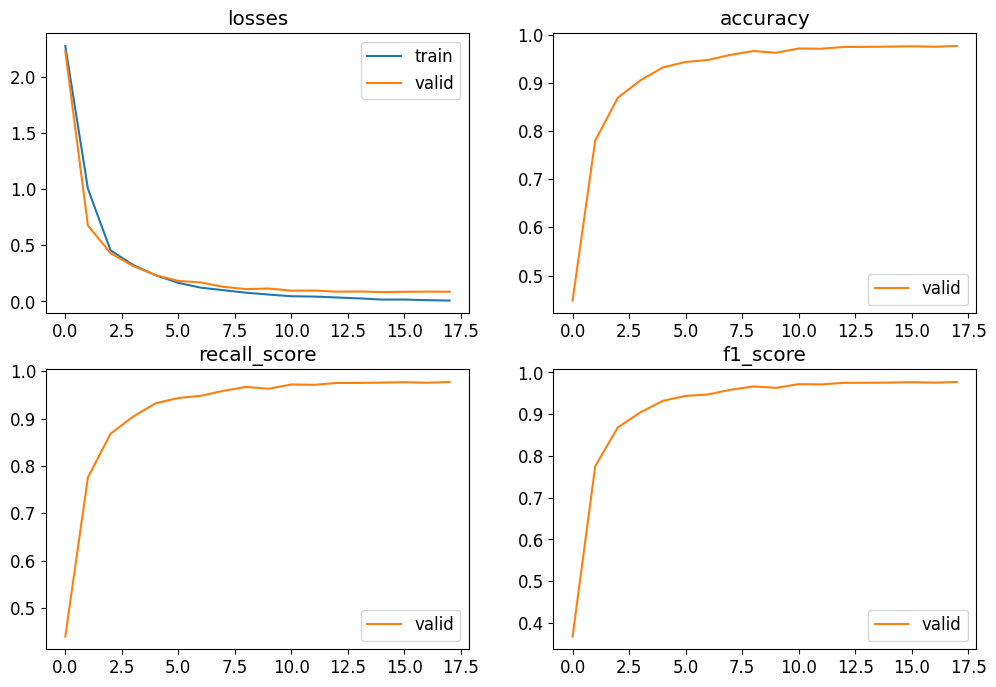

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0867
Accuracy: 0.9773
Recall: 0.9772
F1-Score: 0.9772


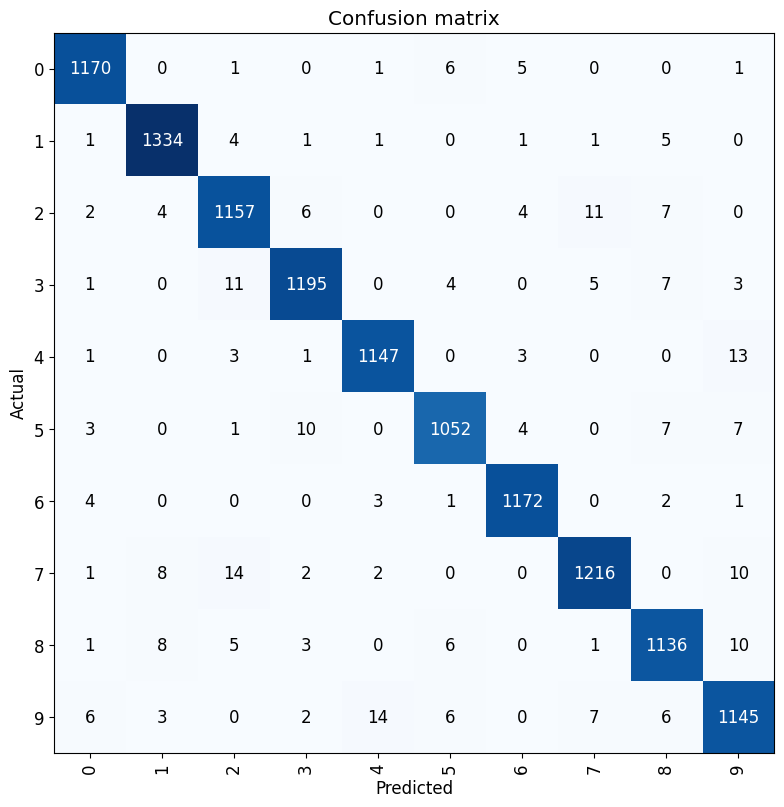

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster01_v4.pkl')

Example 2

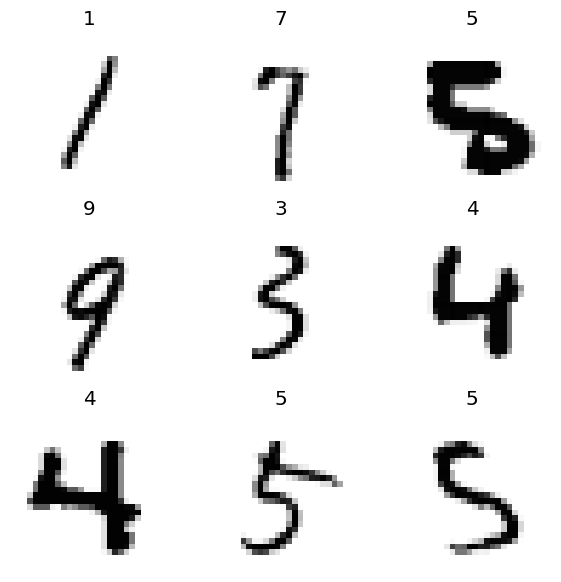

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 13: early stopping

Tiempo de entrenamiento: 513.65 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0940
Accuracy: 0.9758
Recall: 0.9757
F1-Score: 0.9757


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster02_v4.pkl')

Example 3

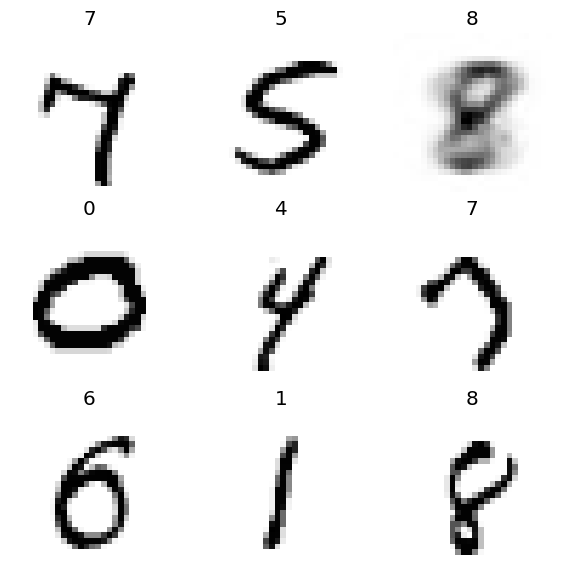

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 12: early stopping

Tiempo de entrenamiento: 277.57 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0906
Accuracy: 0.9747
Recall: 0.9745
F1-Score: 0.9745


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster03_v4.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

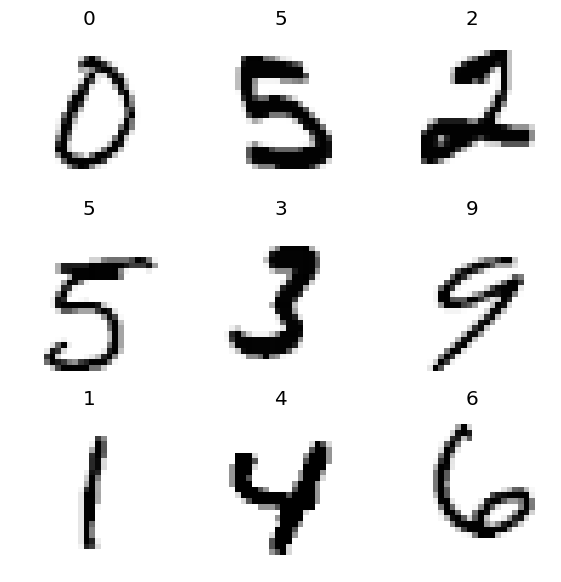

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 9814
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


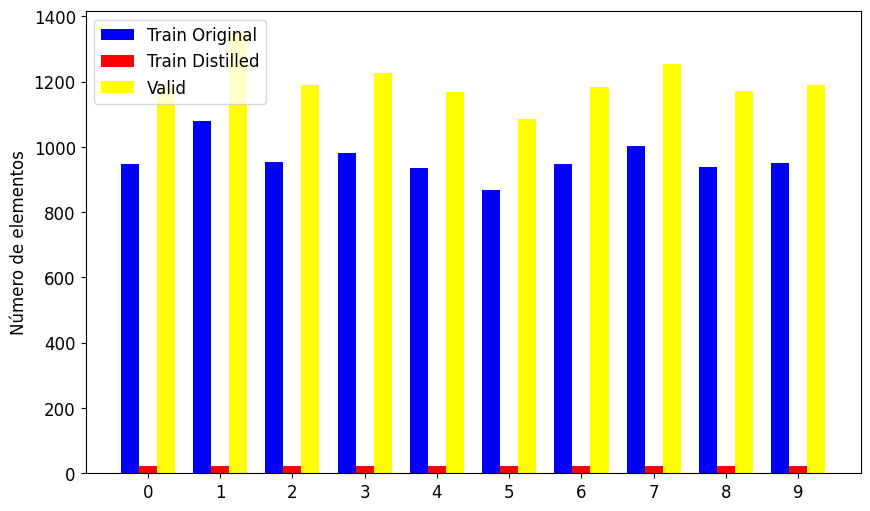

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 392.36 segundos


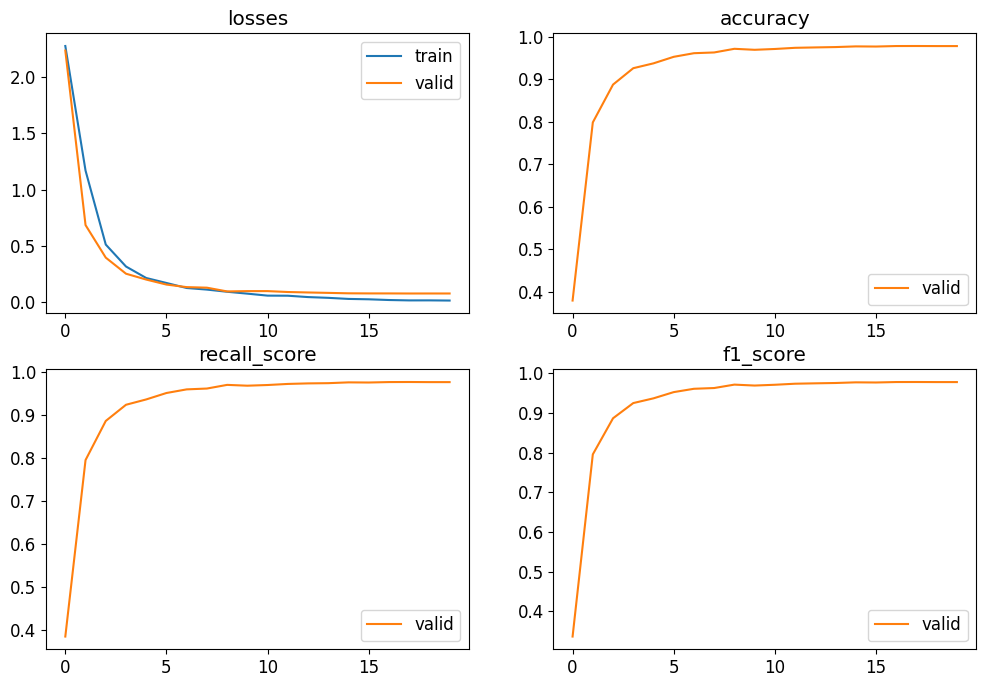

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0793
Accuracy: 0.9777
Recall: 0.9774
F1-Score: 0.9775


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster01_v4.pkl')

Example 2

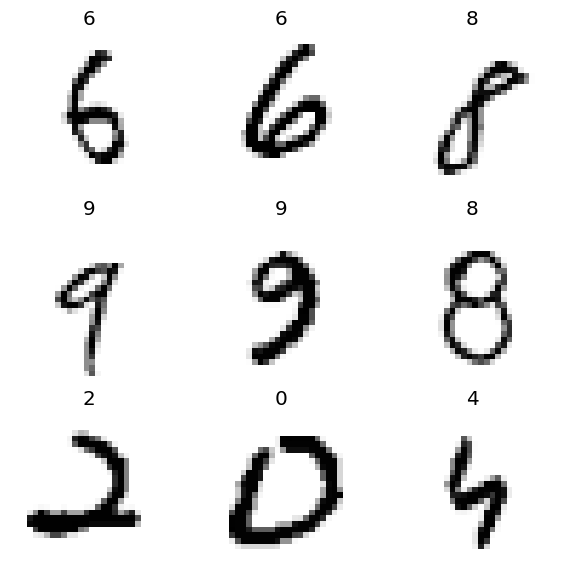

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 496.55 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0845
Accuracy: 0.9766
Recall: 0.9764
F1-Score: 0.9764


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster02_v4.pkl')

Example 3

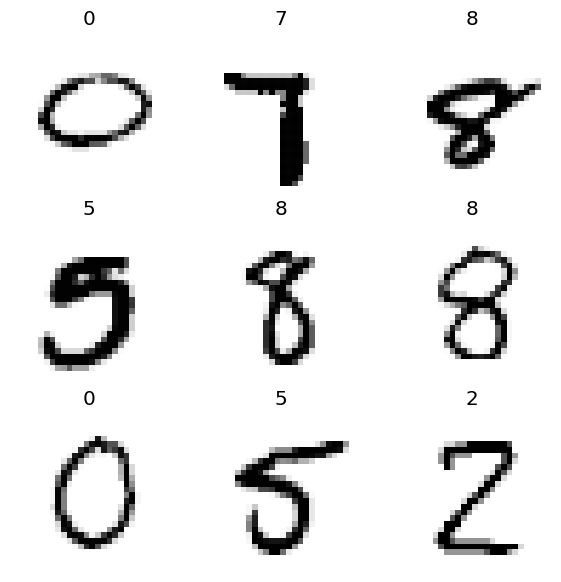

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 13: early stopping

Tiempo de entrenamiento: 388.51 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0850
Accuracy: 0.9776
Recall: 0.9772
F1-Score: 0.9773


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster03_v4.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

eXample 1

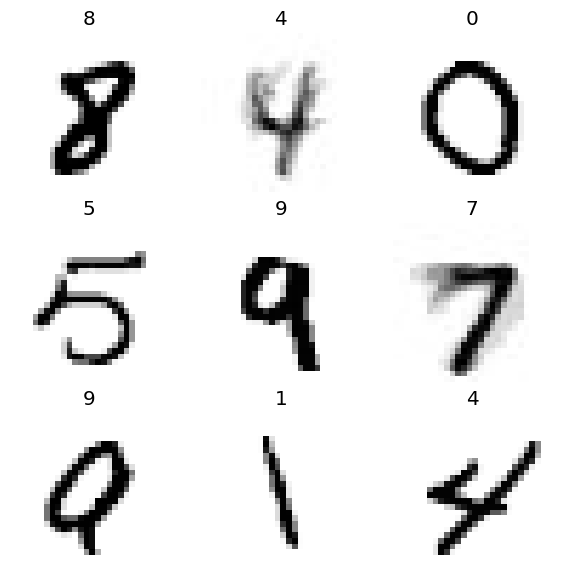

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 21933
Número total de imágenes en validación: 5996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


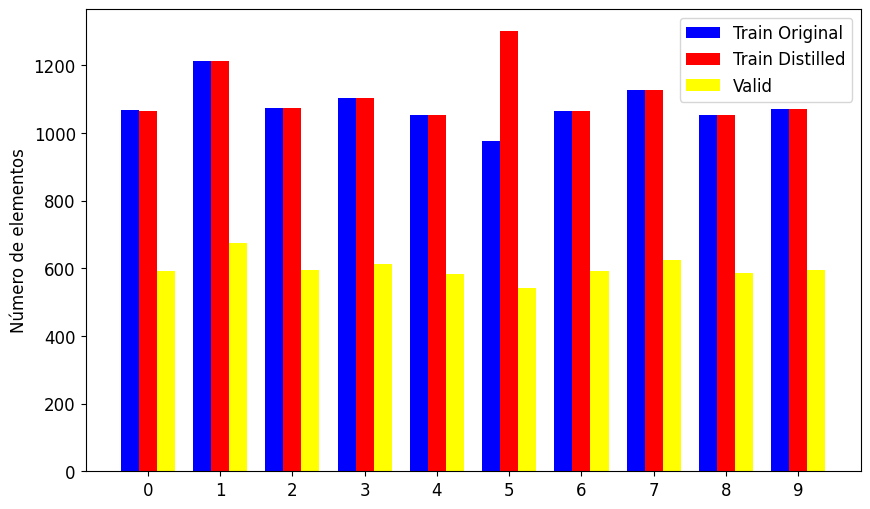

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 13: early stopping

Tiempo de entrenamiento: 516.70 segundos


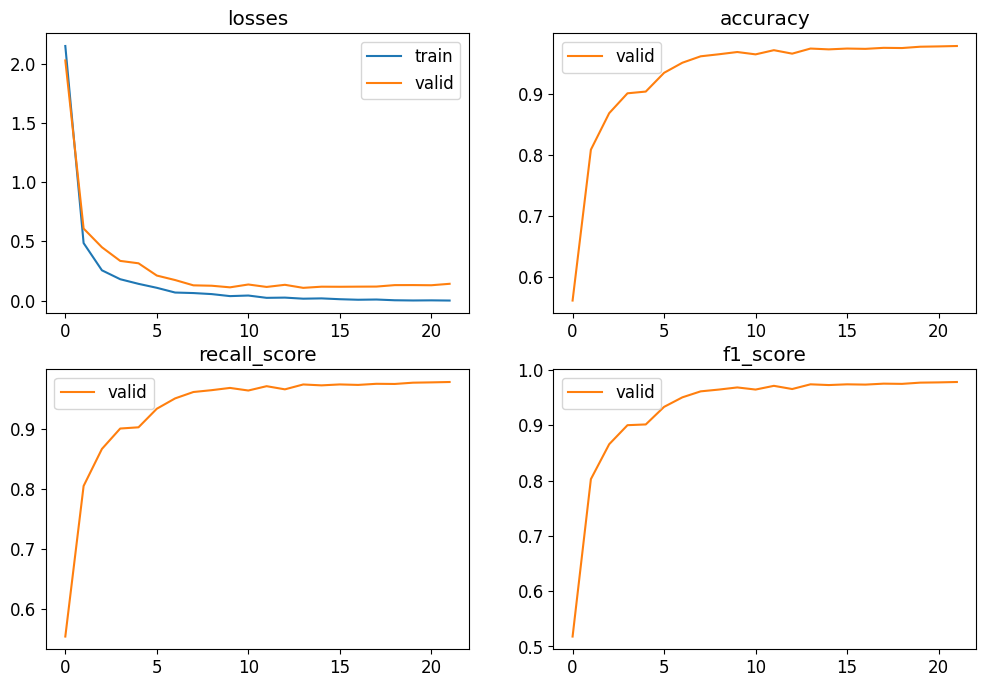

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.1425
Accuracy: 0.9785
Recall: 0.9783
F1-Score: 0.9783


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster01_v4.pkl')

Example 2

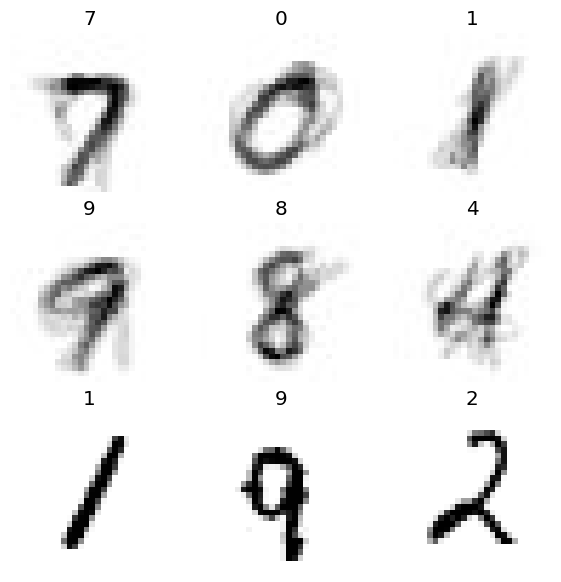

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 13: early stopping

Tiempo de entrenamiento: 479.56 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.1409
Accuracy: 0.9752
Recall: 0.9749
F1-Score: 0.9749


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster02_v4.pkl')

example 3

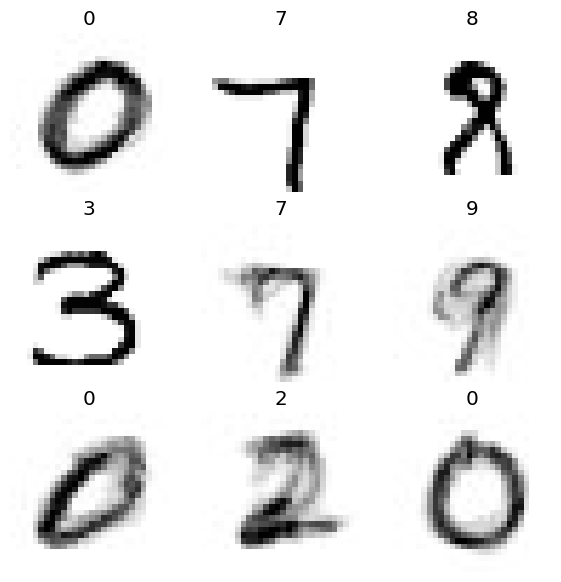

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 15: early stopping

Tiempo de entrenamiento: 521.74 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.1331
Accuracy: 0.9777
Recall: 0.9775
F1-Score: 0.9774


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster03_v4.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

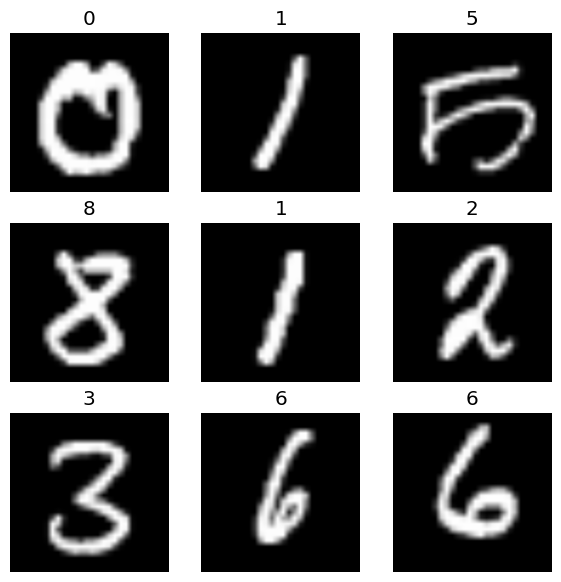

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 10622
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 1321.46 segundos


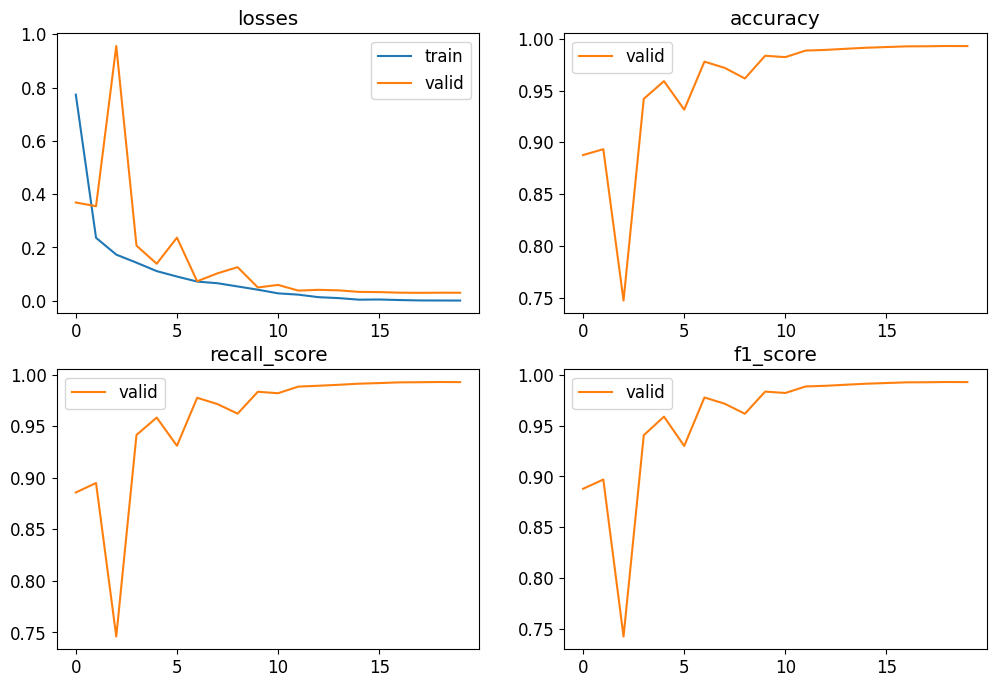

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0300
Accuracy: 0.9930
Recall: 0.9929
F1-Score: 0.9929


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster01_v4.pkl')

Example 2

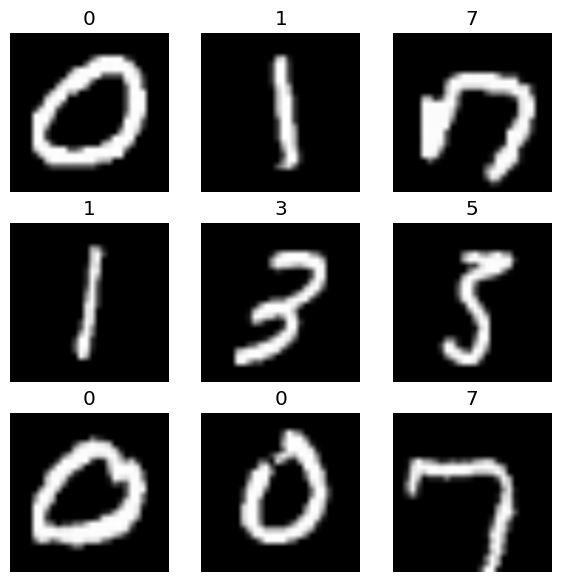

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 15: early stopping

Tiempo de entrenamiento: 1235.77 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0335
Accuracy: 0.9918
Recall: 0.9918
F1-Score: 0.9918


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster02_v4.pkl')

Example 3

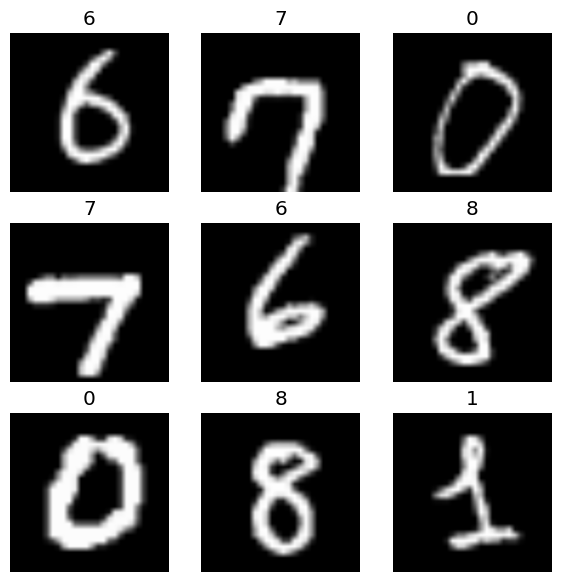

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 454.08 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.1840
Accuracy: 0.9471
Recall: 0.9463
F1-Score: 0.9465


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster03_v4.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

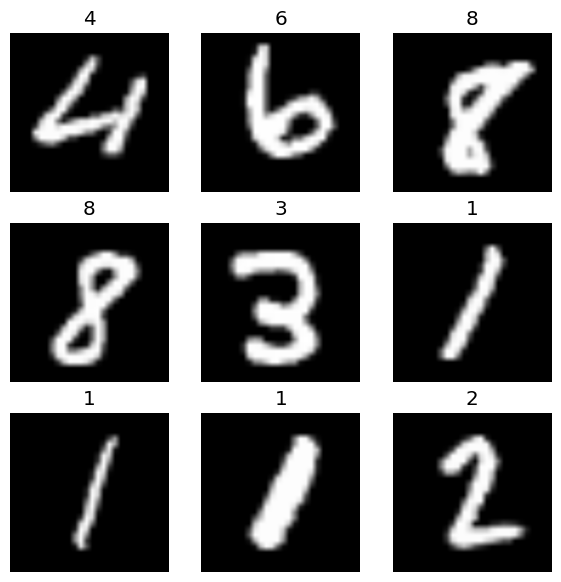

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 9814
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 310.43 segundos


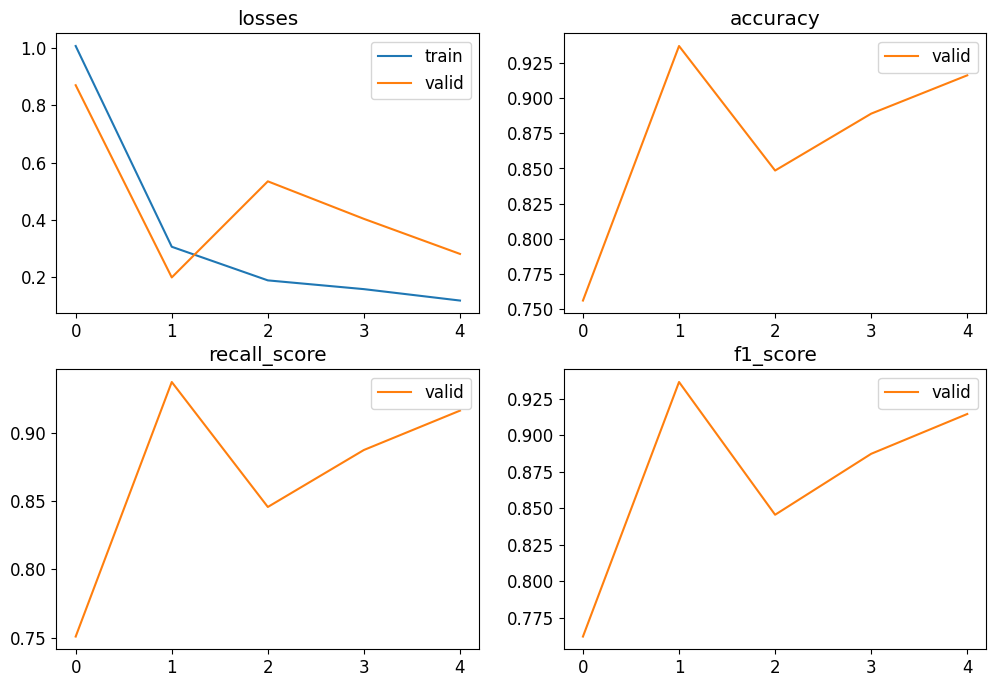

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2814
Accuracy: 0.9165
Recall: 0.9163
F1-Score: 0.9146


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster01_v4.pkl')

Example 2

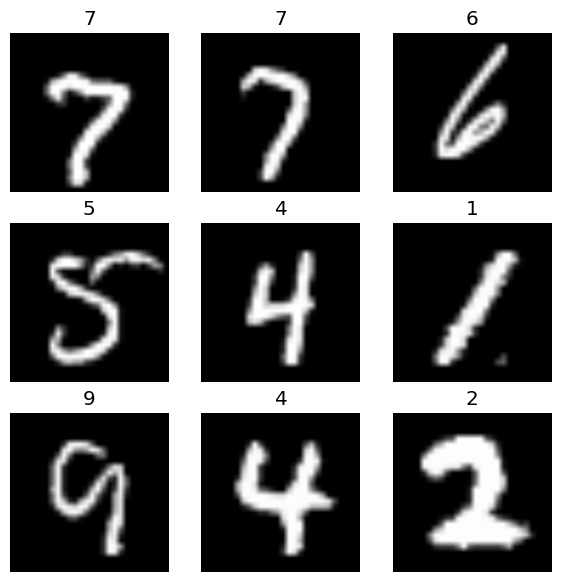

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 372.84 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.6455
Accuracy: 0.8479
Recall: 0.8479
F1-Score: 0.8601


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster02_v4.pkl')

Example 3

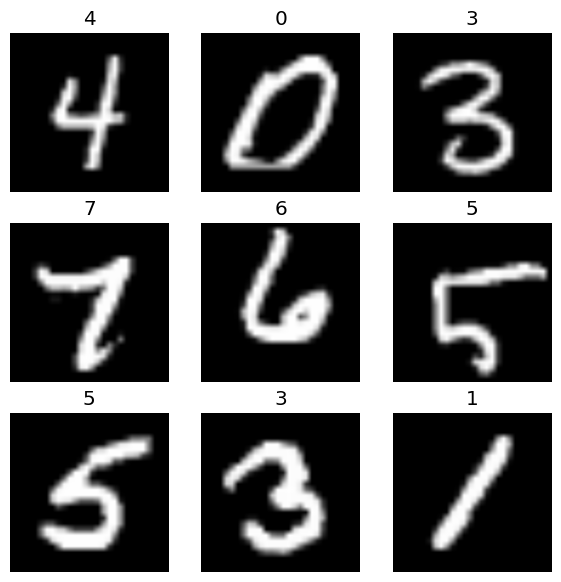

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 1258.94 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0305
Accuracy: 0.9917
Recall: 0.9916
F1-Score: 0.9916


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster03_v4.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

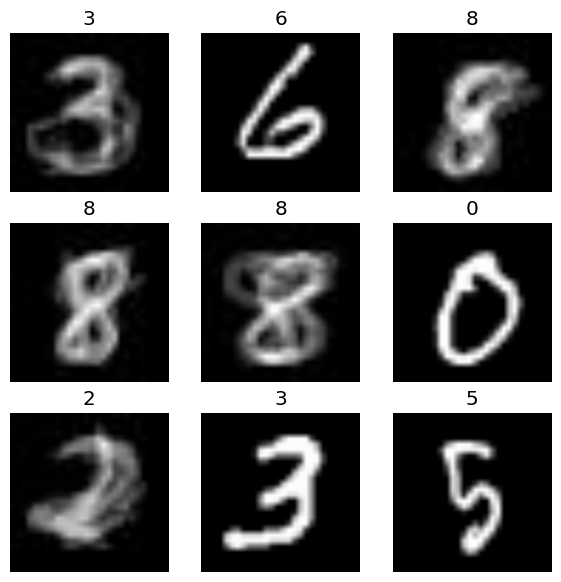

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 21933
Número total de imágenes en validación: 5996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 24: early stopping

Tiempo de entrenamiento: 3144.97 segundos


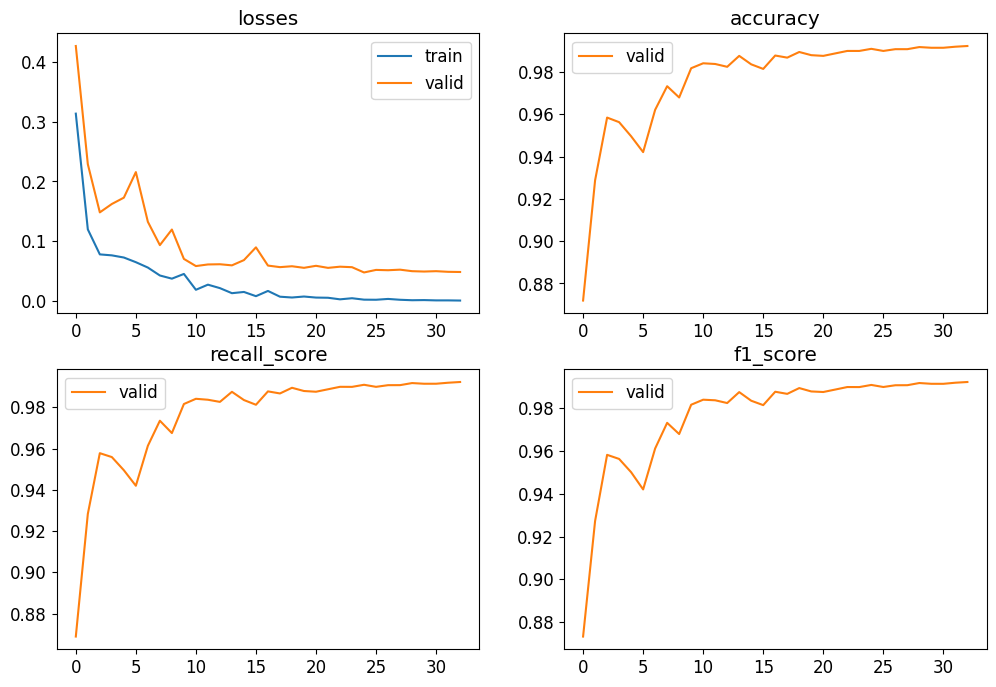

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0480
Accuracy: 0.9923
Recall: 0.9922
F1-Score: 0.9922


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster01_v4.pkl')

Example 2

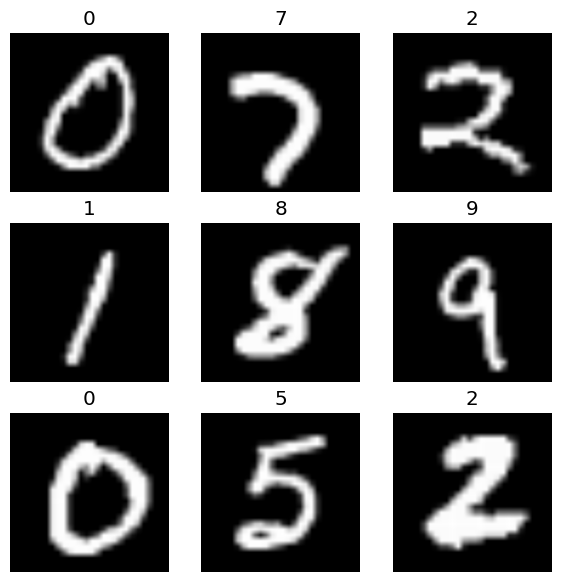

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 21: early stopping

Tiempo de entrenamiento: 2056.19 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0414
Accuracy: 0.9916
Recall: 0.9916
F1-Score: 0.9916


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster02_v4.pkl')

Example 3

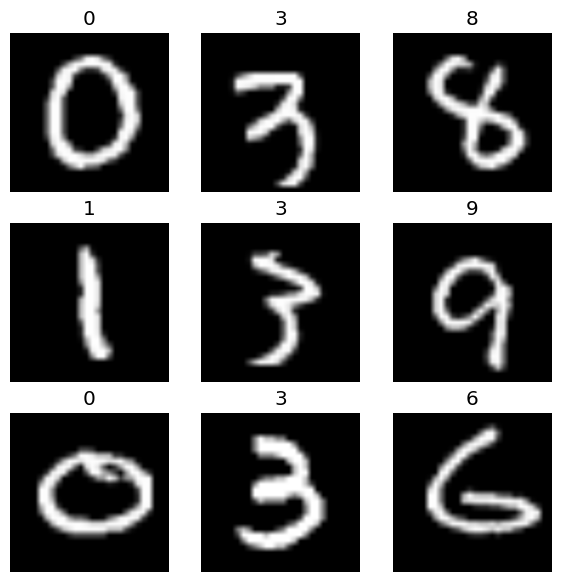

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 30: early stopping

Tiempo de entrenamiento: 2645.86 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0384
Accuracy: 0.9917
Recall: 0.9917
F1-Score: 0.9918


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster03_v4.pkl')

# Apartado 3

In [ ]:
mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_001_path, valid_ratio=0.2, distilled_portion=0.5, group_fraction=0.01, mix_function=media_arit)


In [ ]:
mnist_005_path = base_path / "distilled_005"
mnist_005_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_005_path, valid_ratio=0.2, distilled_portion=0.5, group_fraction=0.05, mix_function=media_arit)

In [ ]:
mnist_0001_path = base_path / "distilled_0001"
mnist_0001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_0001_path, valid_ratio=0.2, distilled_portion=0.5, group_fraction=0.001, mix_function=media_arit)

## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

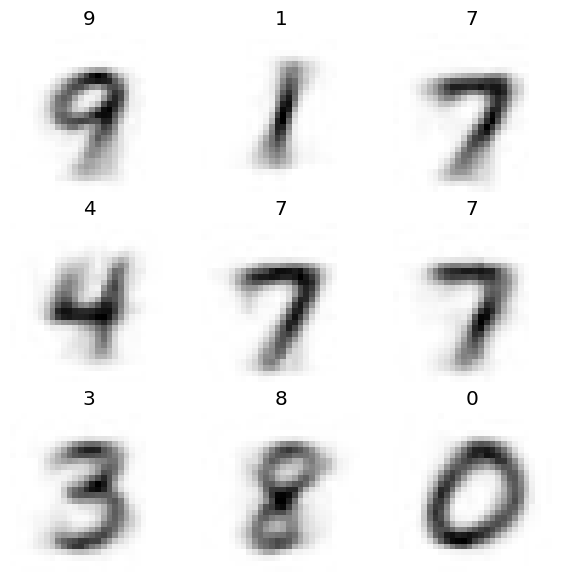

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 496
Número total de imágenes en validación: 596

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


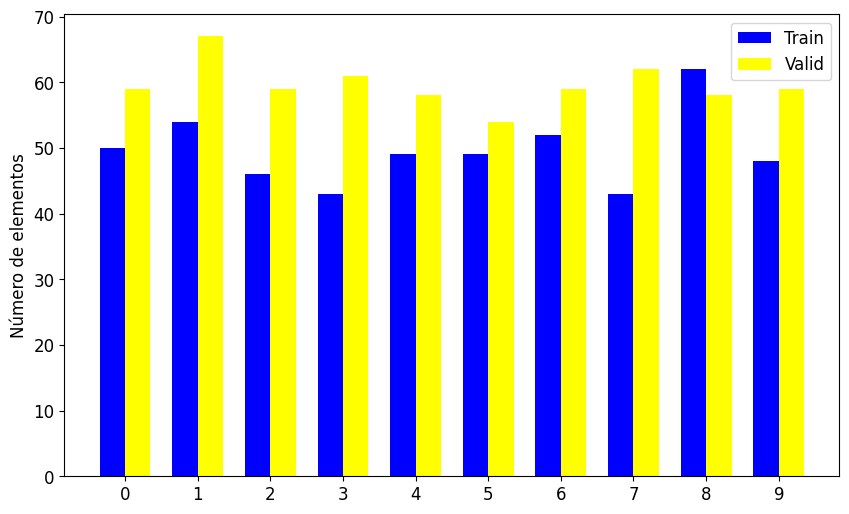

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 17.84 segundos


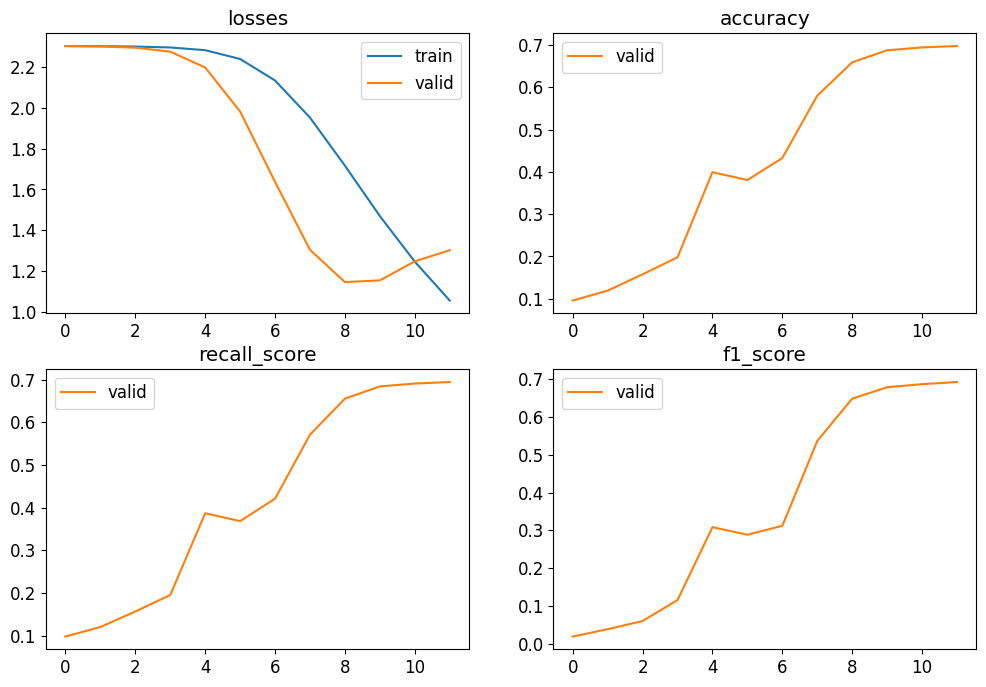

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3024
Accuracy: 0.6980
Recall: 0.6942
F1-Score: 0.6929


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster01_v4.pkl')

Example 2

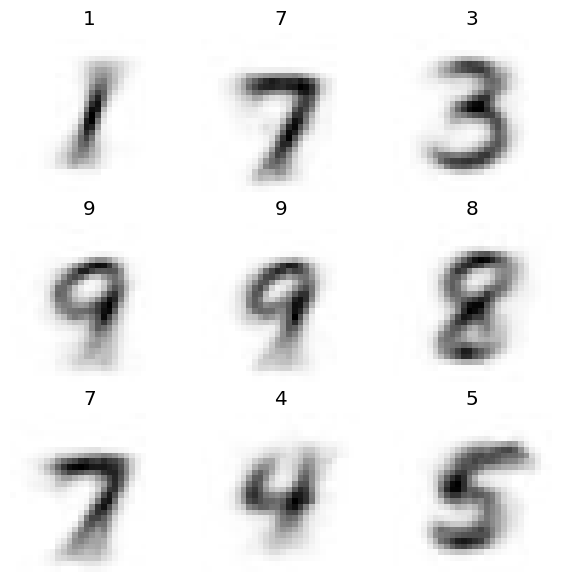

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 18.75 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.6095
Accuracy: 0.6309
Recall: 0.6270
F1-Score: 0.6241


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster02_v4.pkl')

Example 3

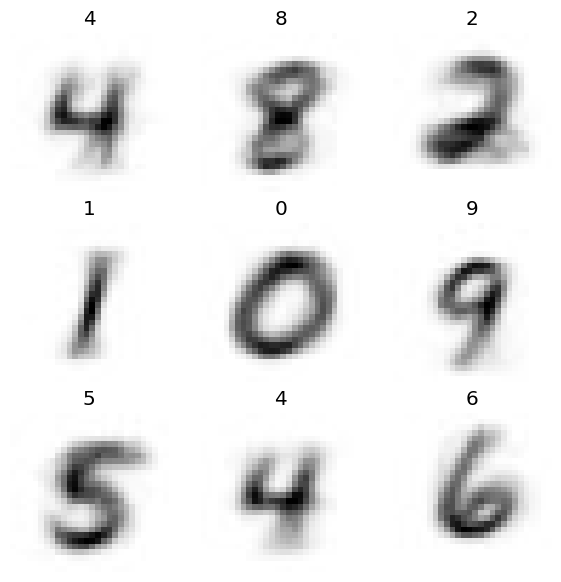

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 12.97 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3057
Accuracy: 0.7114
Recall: 0.7059
F1-Score: 0.7089


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster03_v4.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

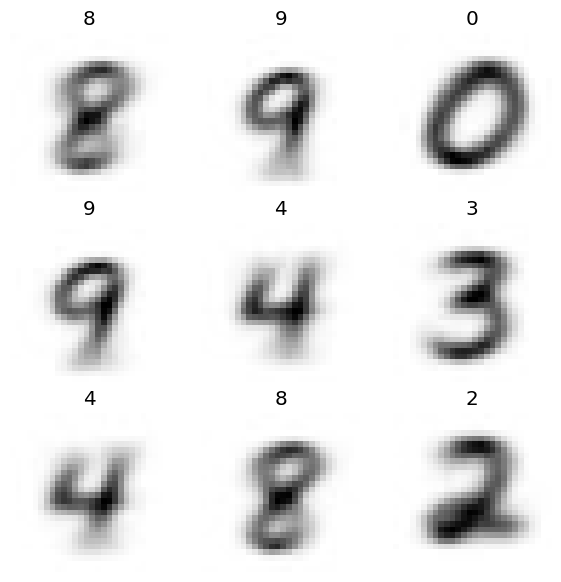

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 106
Número total de imágenes en validación: 295

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


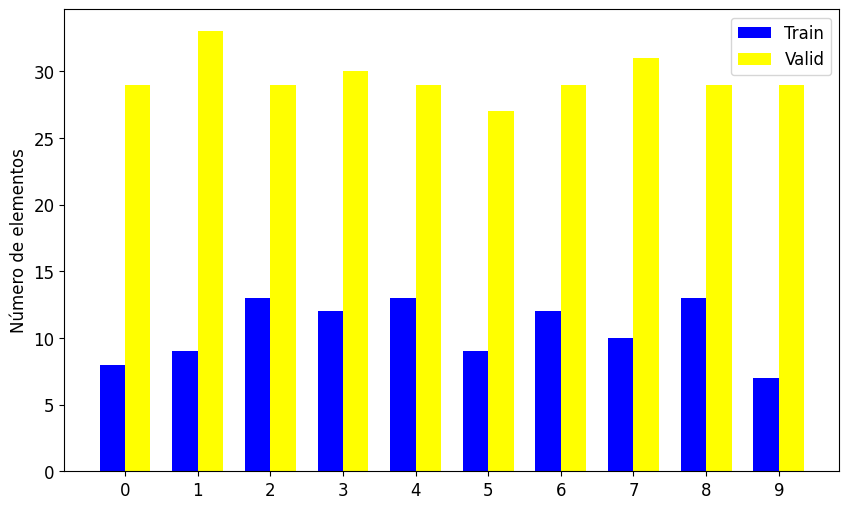

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 12.83 segundos


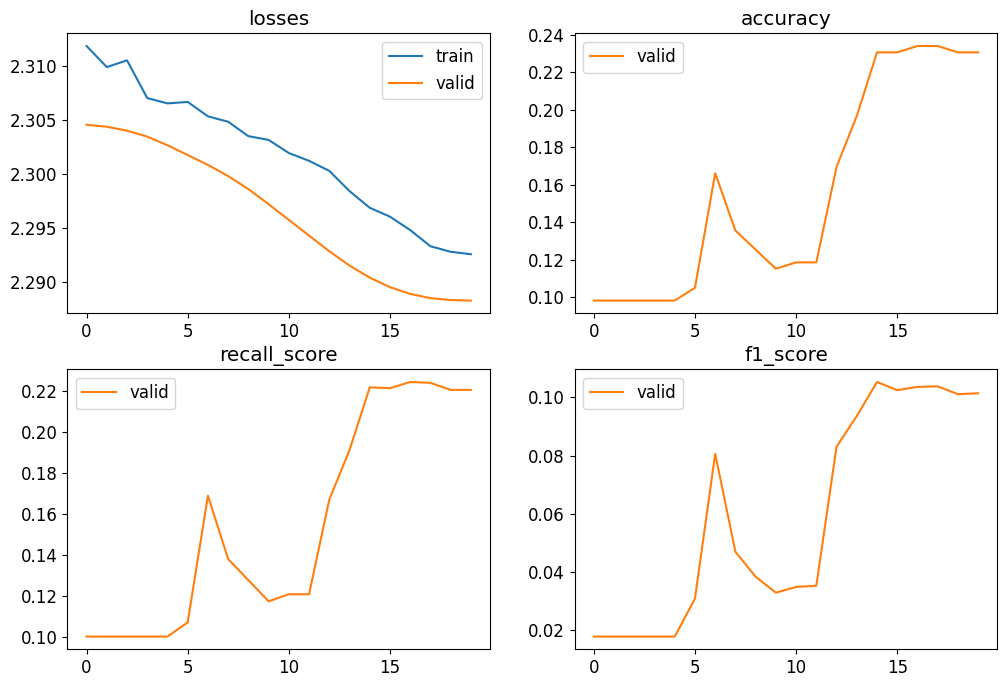

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2883
Accuracy: 0.2305
Recall: 0.2207
F1-Score: 0.1014


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster01_v4.pkl')

Example 2

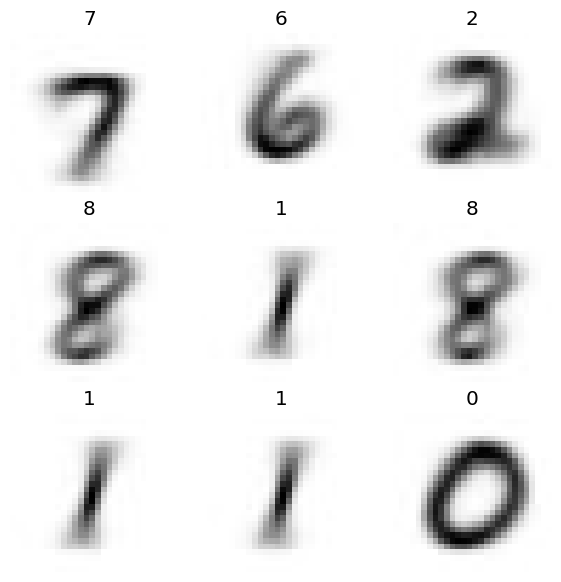

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 16.89 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2882
Accuracy: 0.2576
Recall: 0.2563
F1-Score: 0.1528


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster02_v4.pkl')

Example 3

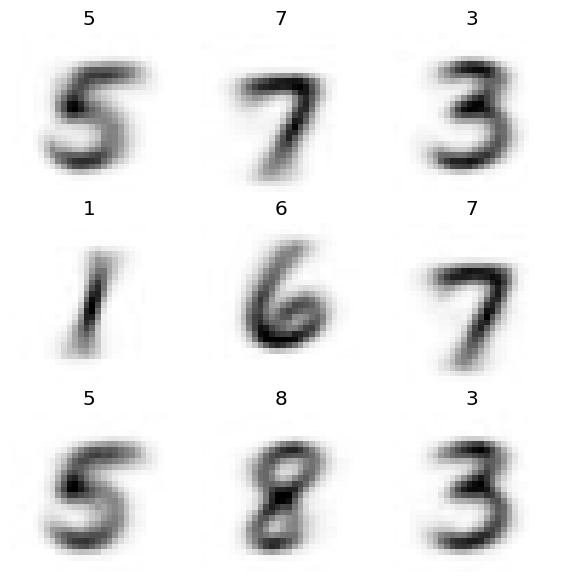

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 12.34 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2548
Accuracy: 0.2576
Recall: 0.2490
F1-Score: 0.1933


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_2cluster03_v4.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

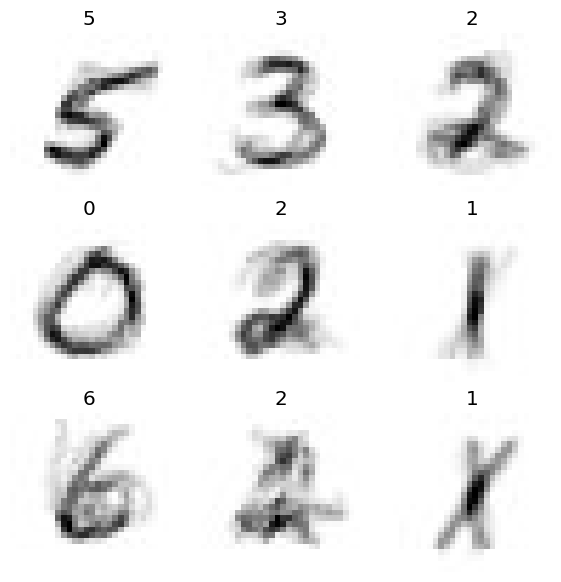

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 5501
Número total de imágenes en validación: 5996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


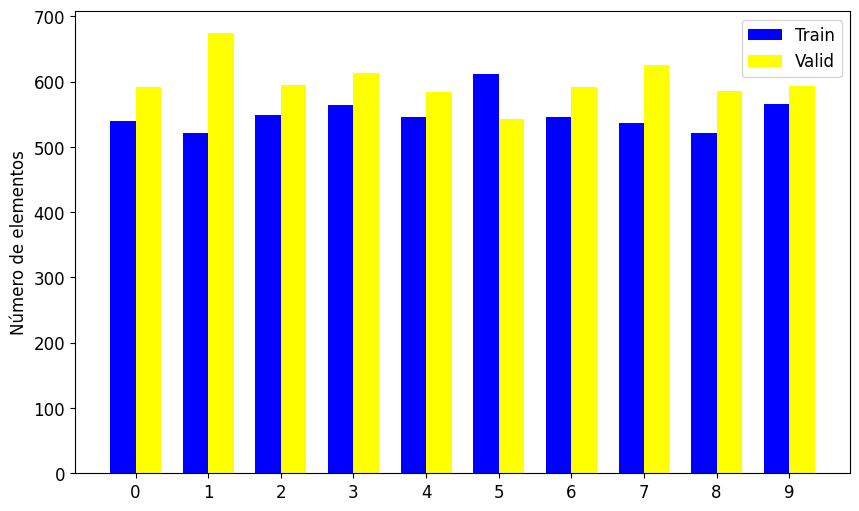

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 127.37 segundos


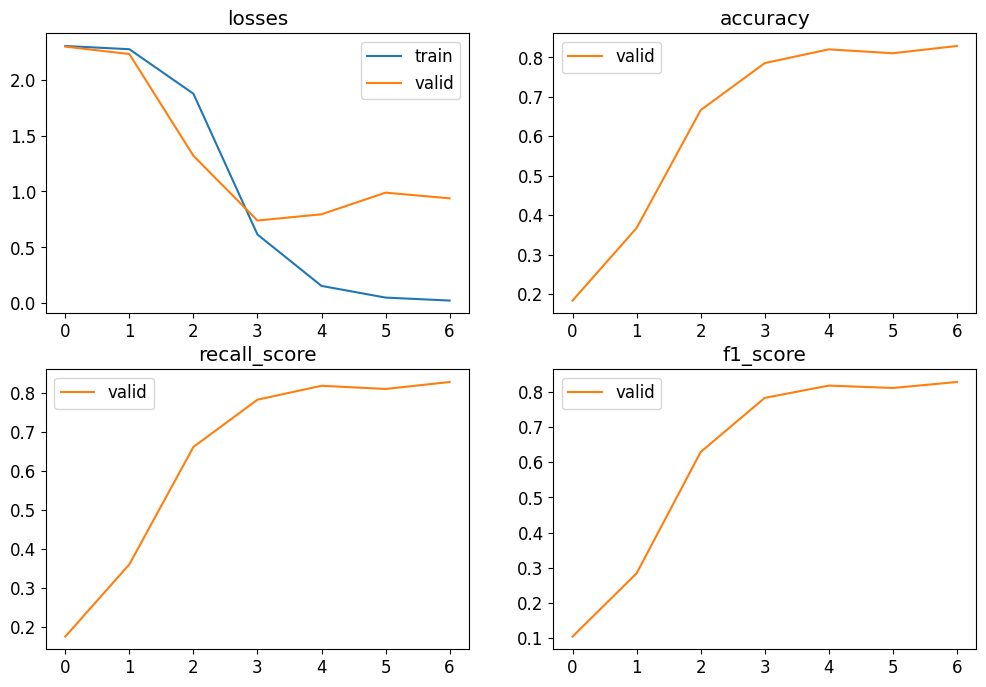

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9389
Accuracy: 0.8291
Recall: 0.8282
F1-Score: 0.8286


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster01_v4.pkl')

Exampel 2

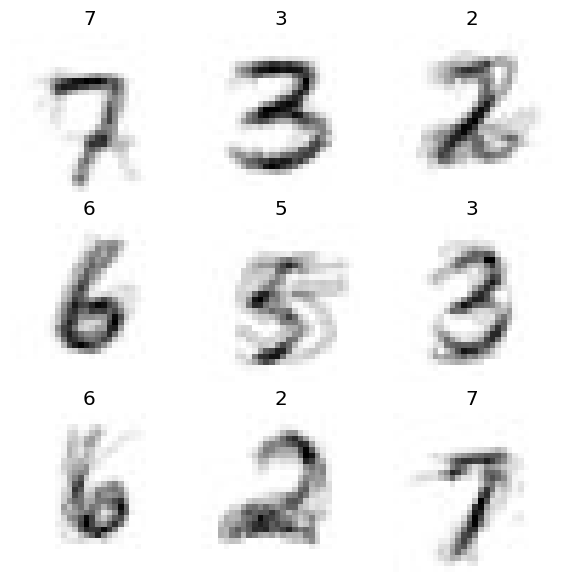

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 101.73 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9535
Accuracy: 0.8145
Recall: 0.8137
F1-Score: 0.8142


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster02_v4.pkl')

Example 3

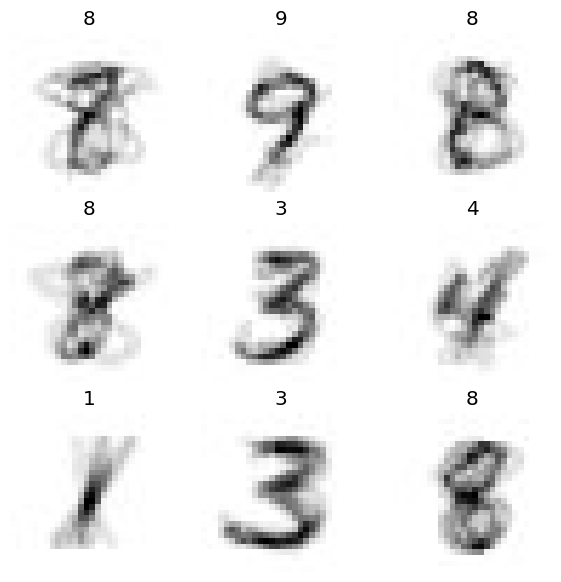

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 79.96 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.0932
Accuracy: 0.7922
Recall: 0.7916
F1-Score: 0.7896


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_2cluster03_v4.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

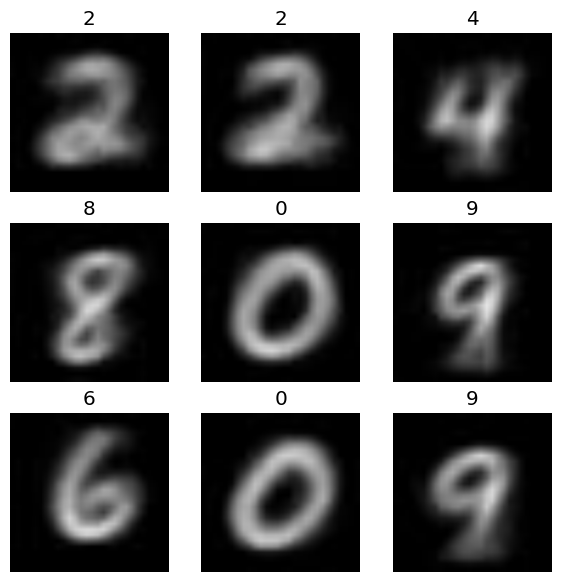

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 502
Número total de imágenes en validación: 596

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 17.76 segundos


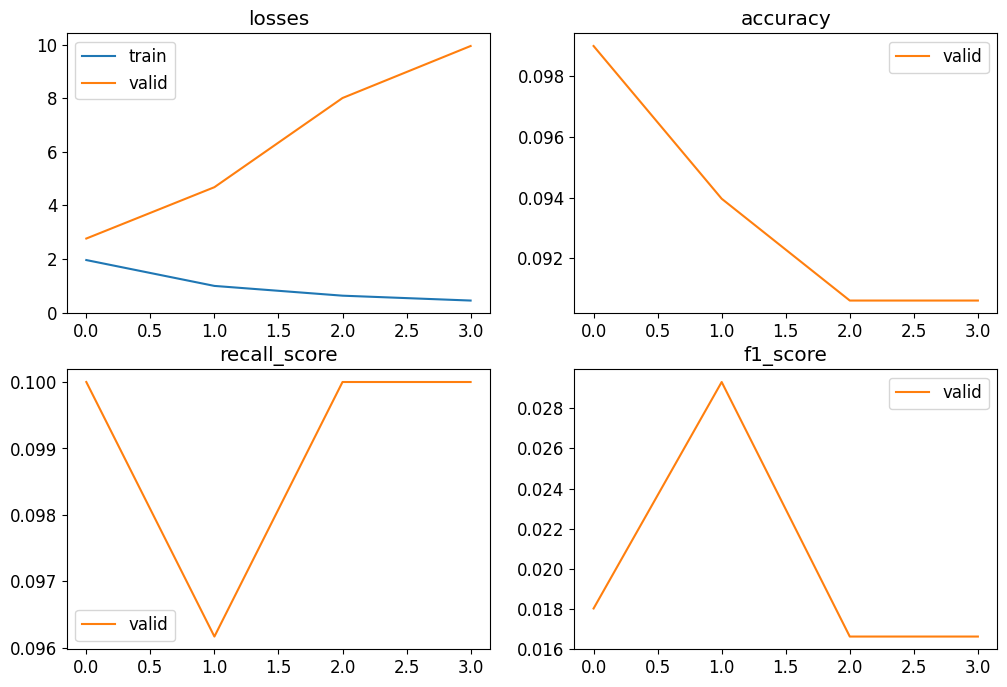

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 9.9477
Accuracy: 0.0906
Recall: 0.1000
F1-Score: 0.0166


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster01_v4.pkl')

Exaple 2

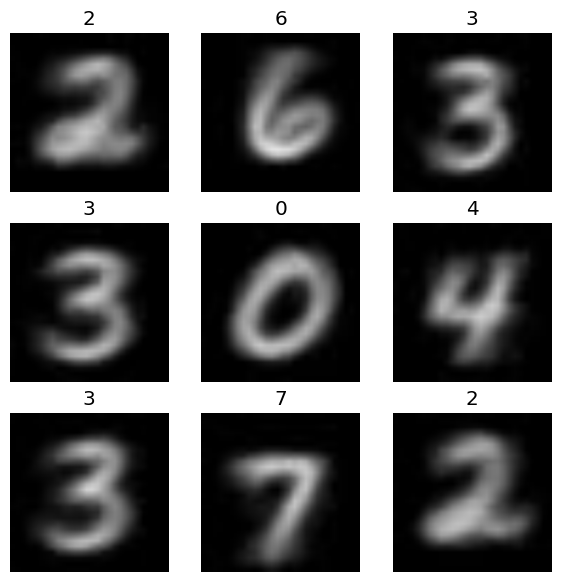

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 14.43 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 14.6313
Accuracy: 0.0906
Recall: 0.1000
F1-Score: 0.0166


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster02_v4.pkl')

Example 3

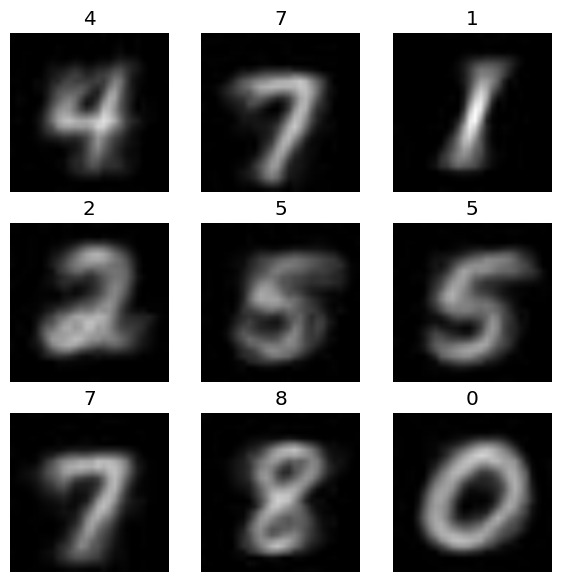

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 14.40 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 11.6779
Accuracy: 0.0906
Recall: 0.1000
F1-Score: 0.0166


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_2cluster03_v4.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

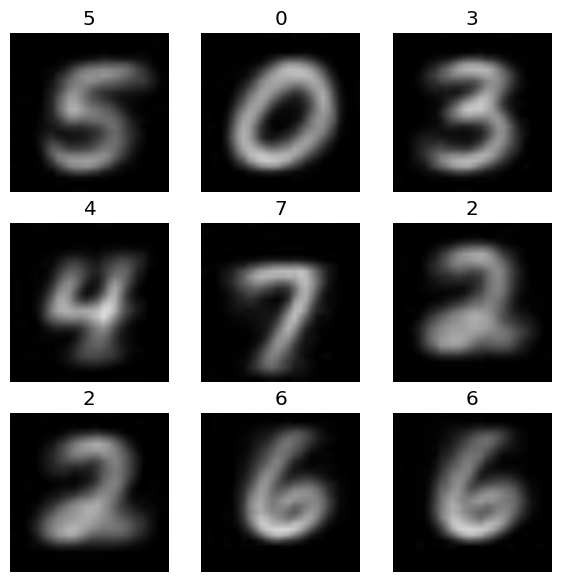

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 104
Número total de imágenes en validación: 295

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 5.14 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.6361
Accuracy: 0.1085
Recall: 0.1134
F1-Score: 0.0422


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster01_v4.pkl')

Example 2

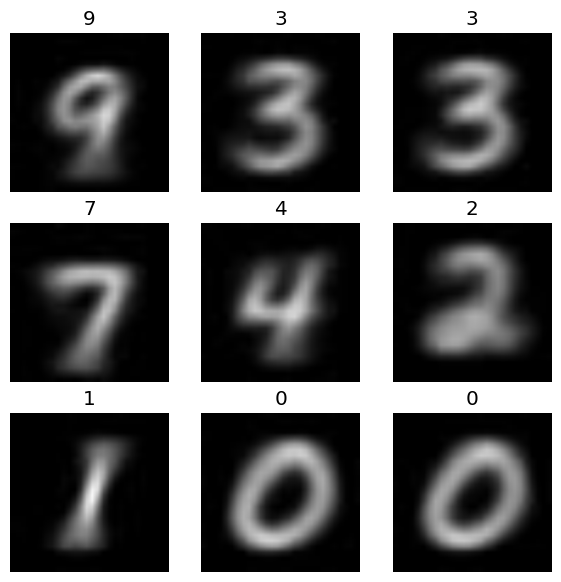

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 5.47 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.5601
Accuracy: 0.0949
Recall: 0.1034
F1-Score: 0.0222


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster02_v4.pkl')

Example 3

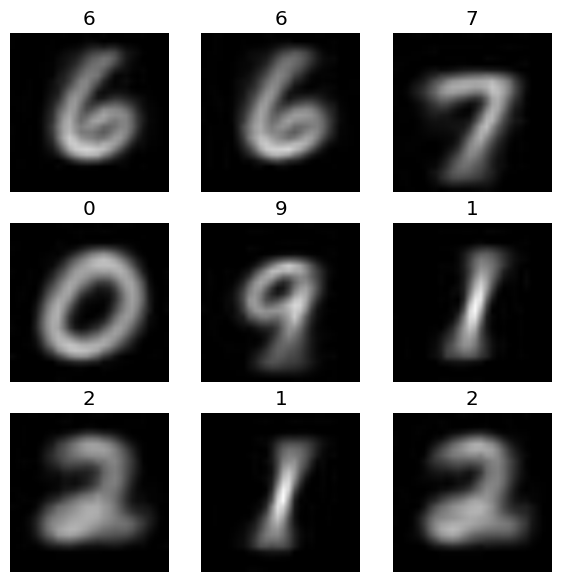

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 8.63 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.3713
Accuracy: 0.0915
Recall: 0.1000
F1-Score: 0.0168


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster03_v4.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

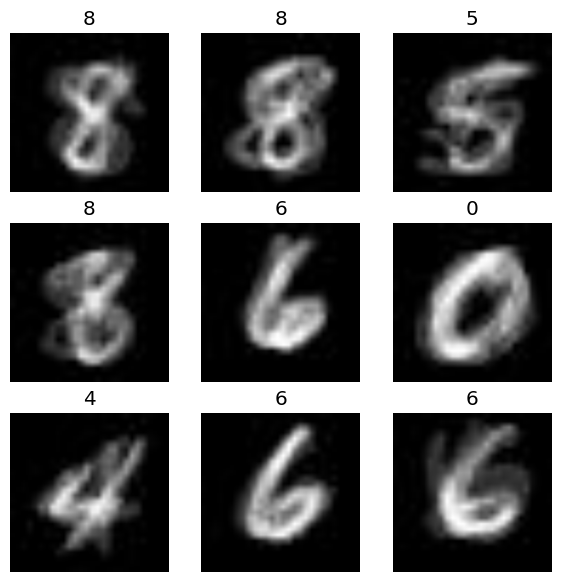

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 5441
Número total de imágenes en validación: 5996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 23: early stopping

Tiempo de entrenamiento: 1052.12 segundos


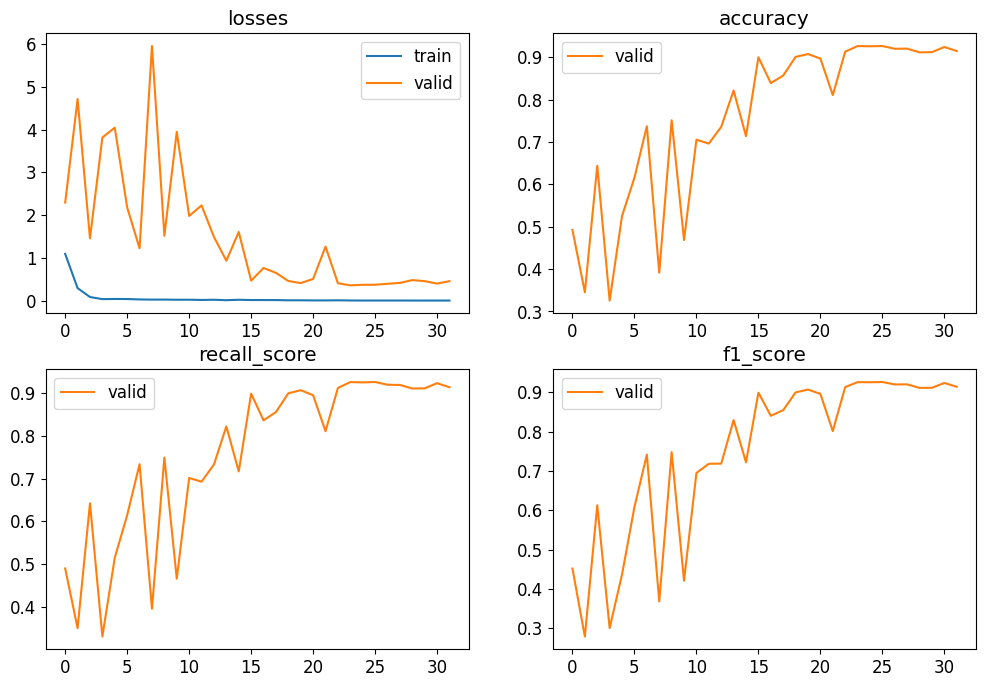

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4535
Accuracy: 0.9146
Recall: 0.9145
F1-Score: 0.9141


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster01_v4.pkl')

Example 2

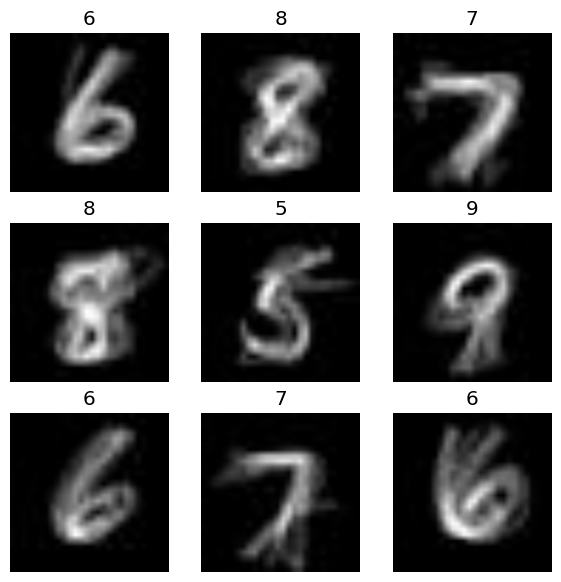

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 6: early stopping

Tiempo de entrenamiento: 479.26 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9900
Accuracy: 0.8079
Recall: 0.8063
F1-Score: 0.8055


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster02_v4.pkl')

Example 3

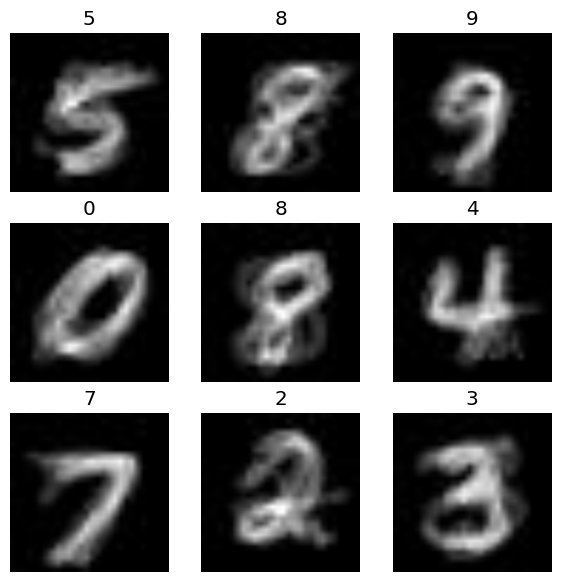

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 17: early stopping

Tiempo de entrenamiento: 831.42 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3471
Accuracy: 0.9281
Recall: 0.9277
F1-Score: 0.9273


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_2cluster04_v3.pkl')

# Apartado 4

In [ ]:
mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_001_path, valid_ratio=0.2, distilled_portion=0.99, group_fraction=0.01, mix_function=media_arit)


In [ ]:
mnist_005_path = base_path / "distilled_005"
mnist_005_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_005_path, valid_ratio=0.2, distilled_portion=0.99, group_fraction=0.05, mix_function=media_arit)

In [ ]:
mnist_0001_path = base_path / "distilled_0001"
mnist_0001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_0001_path, valid_ratio=0.2, distilled_portion=0.99, group_fraction=0.001, mix_function=media_arit)

## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

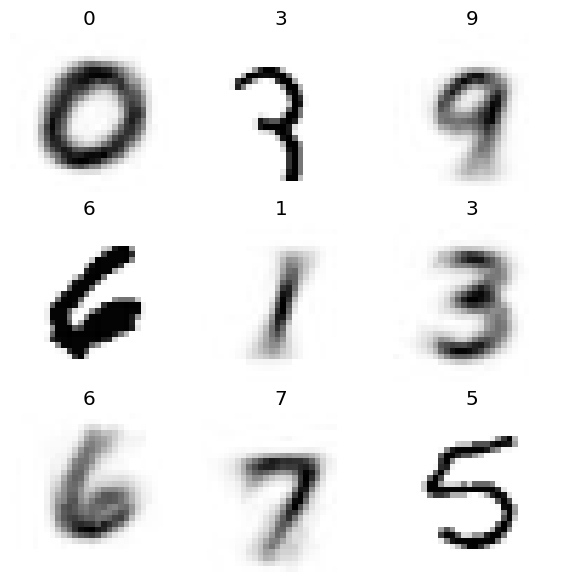

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 1501
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


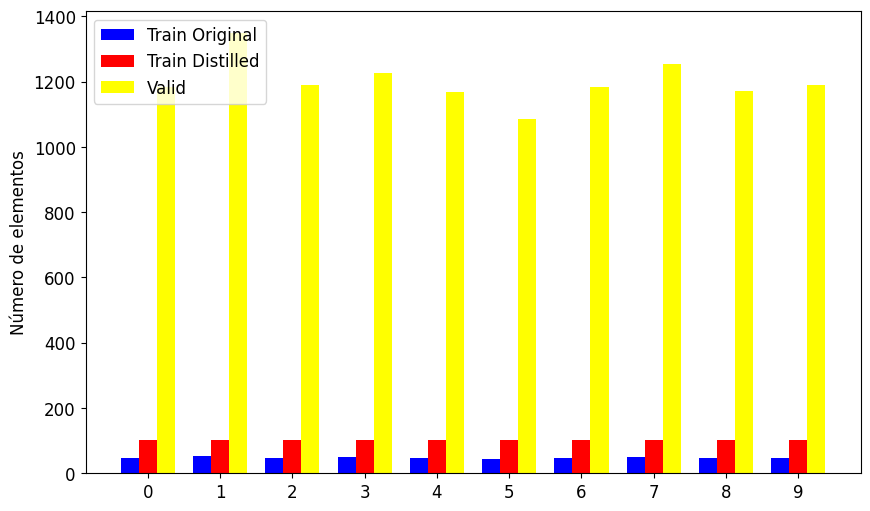

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 16: early stopping

Tiempo de entrenamiento: 252.06 segundos


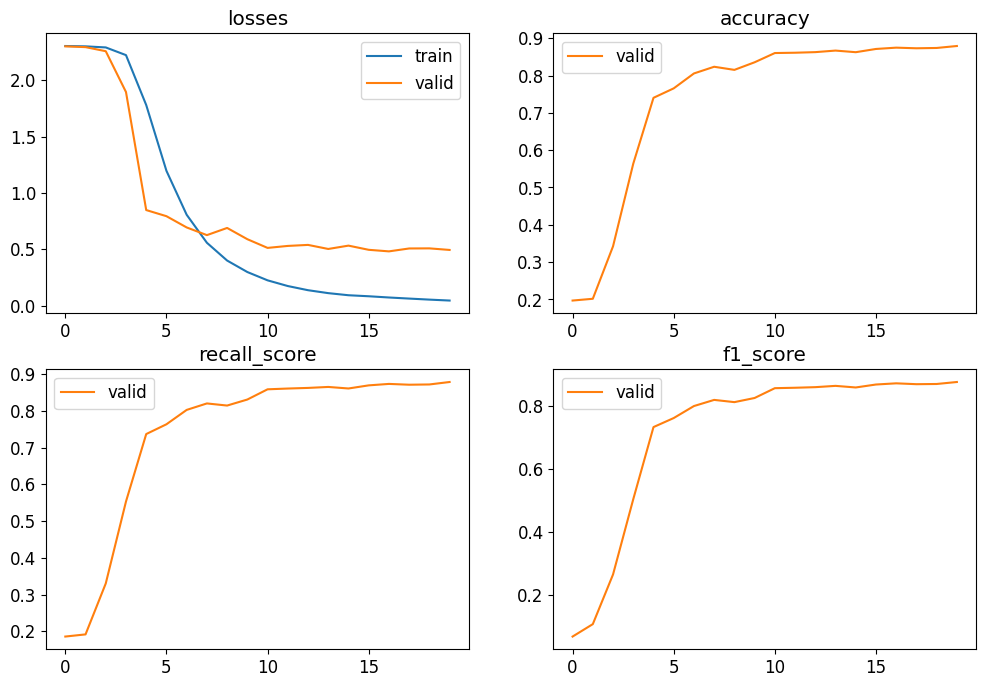

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4944
Accuracy: 0.8790
Recall: 0.8781
F1-Score: 0.8776


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster01_v4.pkl')

Example 2

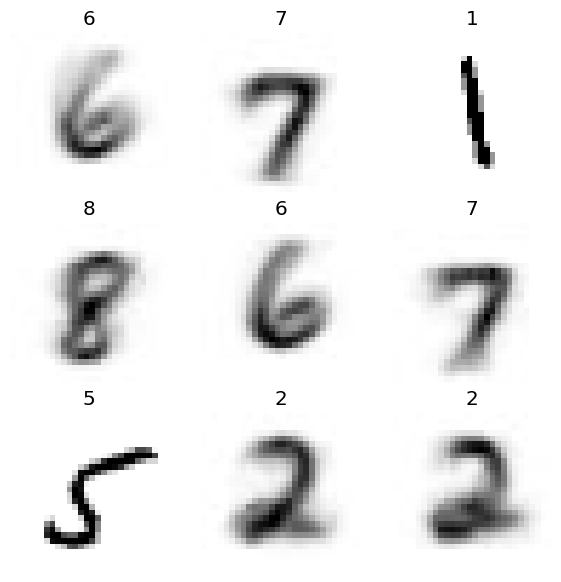

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 123.81 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.5874
Accuracy: 0.8313
Recall: 0.8308
F1-Score: 0.8304


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster03_v4.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

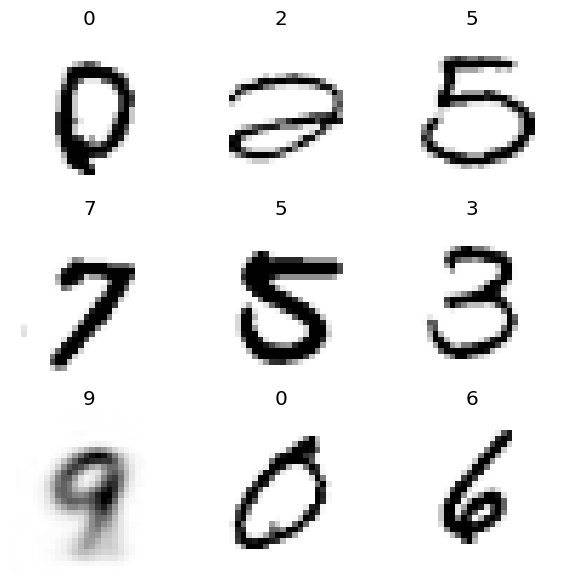

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 694
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


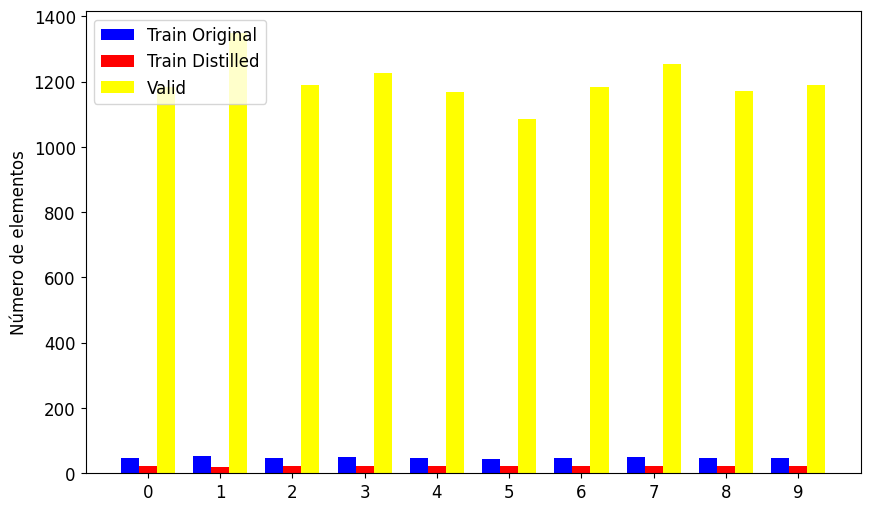

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 205.94 segundos


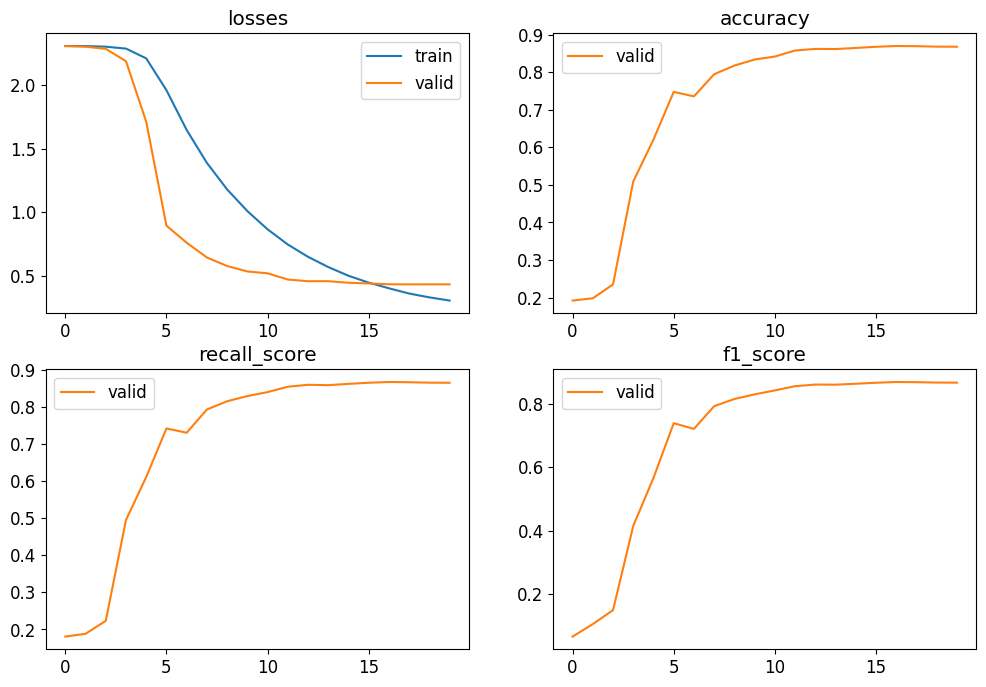

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4357
Accuracy: 0.8682
Recall: 0.8661
F1-Score: 0.8662


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster01_v4.pkl')

Example 2

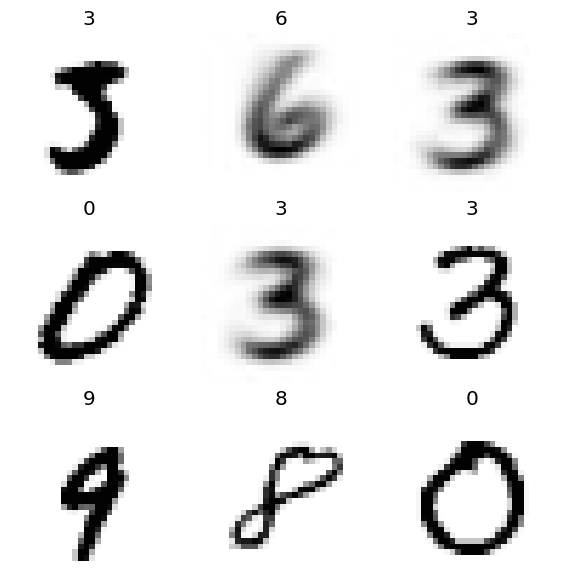

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 191.61 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4513
Accuracy: 0.8595
Recall: 0.8578
F1-Score: 0.8580


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster03_v4.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

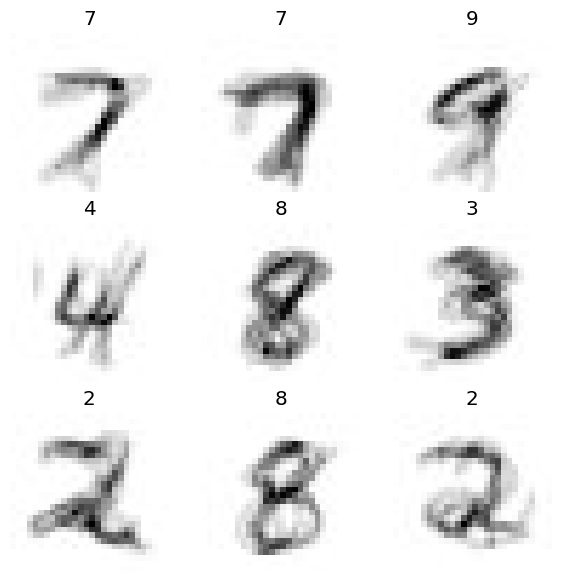

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 12101
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


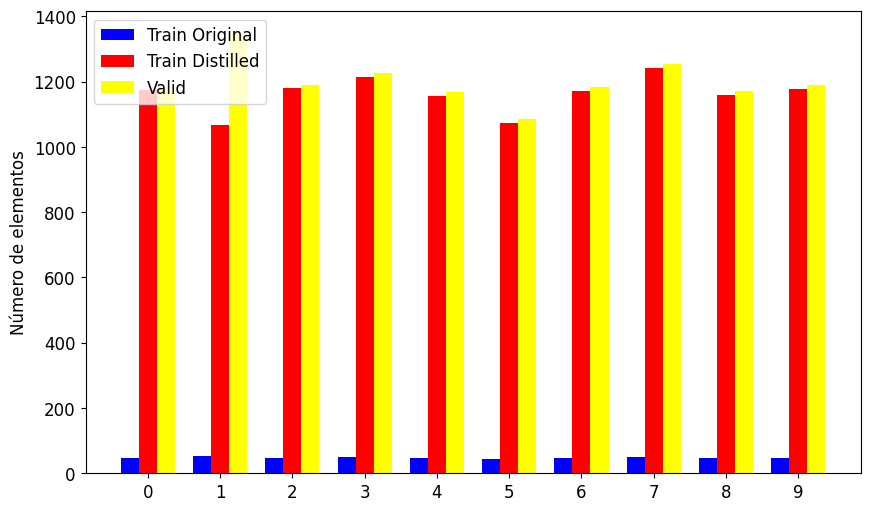

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 11: early stopping

Tiempo de entrenamiento: 276.19 segundos


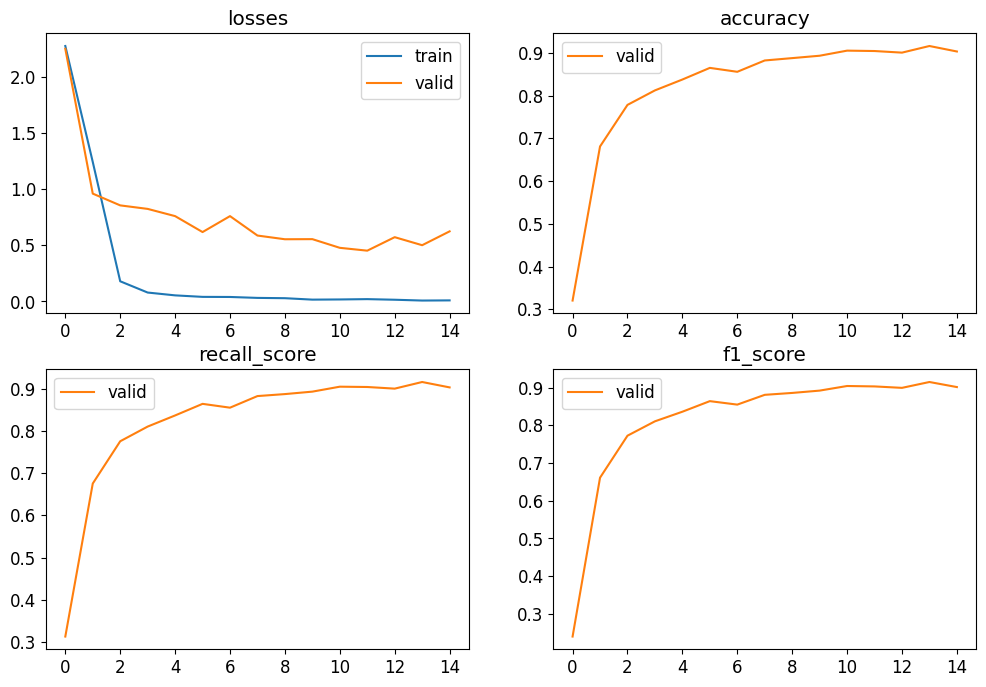

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.6248
Accuracy: 0.9032
Recall: 0.9028
F1-Score: 0.9016


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster01_v4.pkl')

Exampel 2

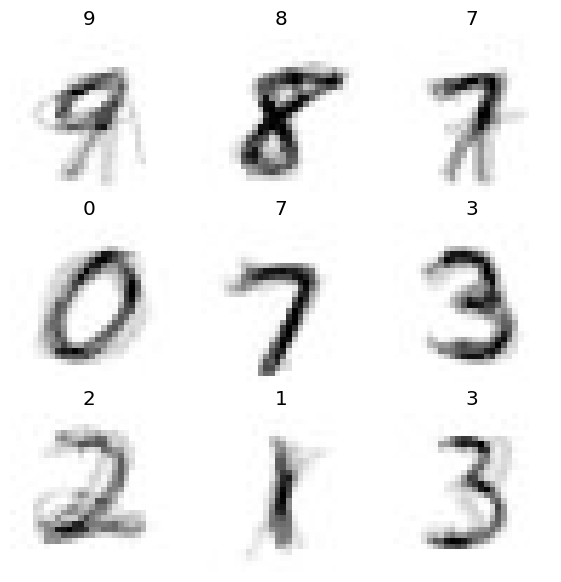

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 202.44 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.6228
Accuracy: 0.8785
Recall: 0.8784
F1-Score: 0.8775


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster03_v4.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

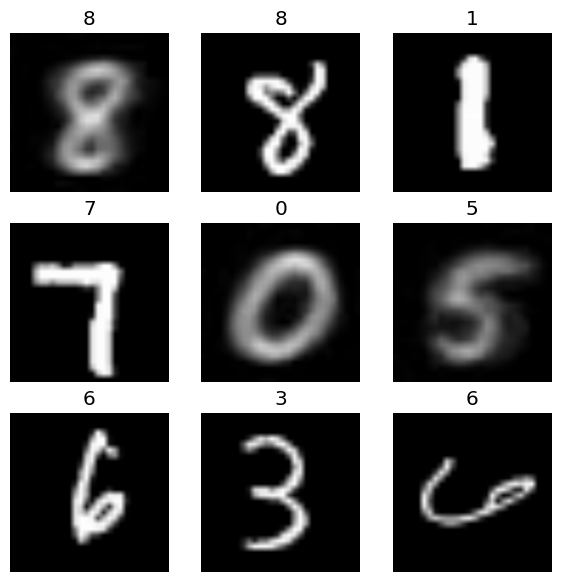

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 1501
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 370.43 segundos


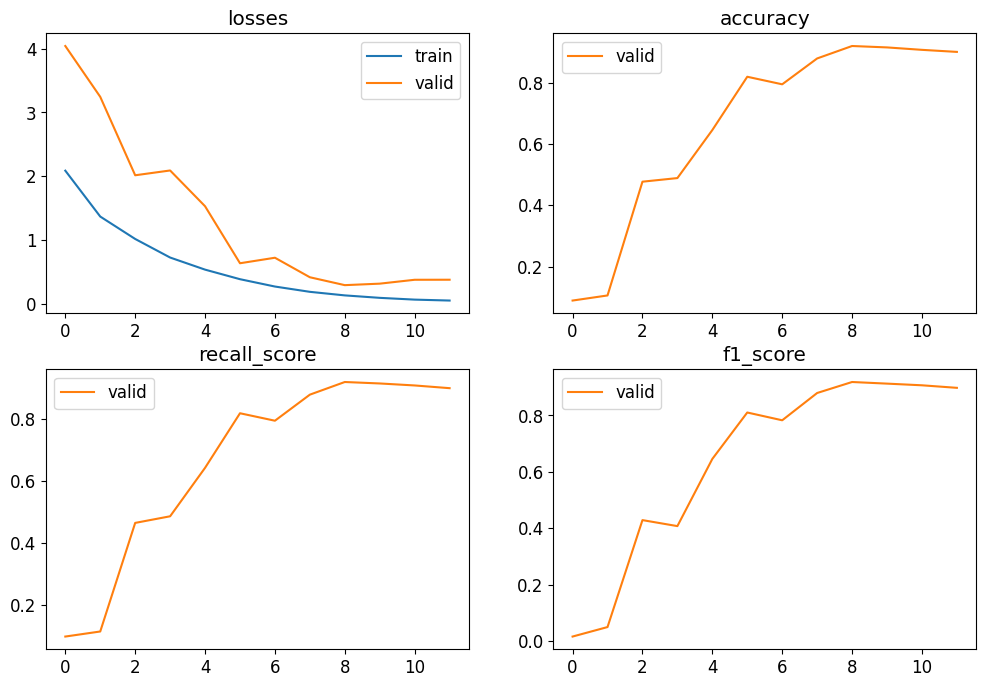

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3737
Accuracy: 0.8999
Recall: 0.8978
F1-Score: 0.8980


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster01_v4.pkl')

Exaple 2

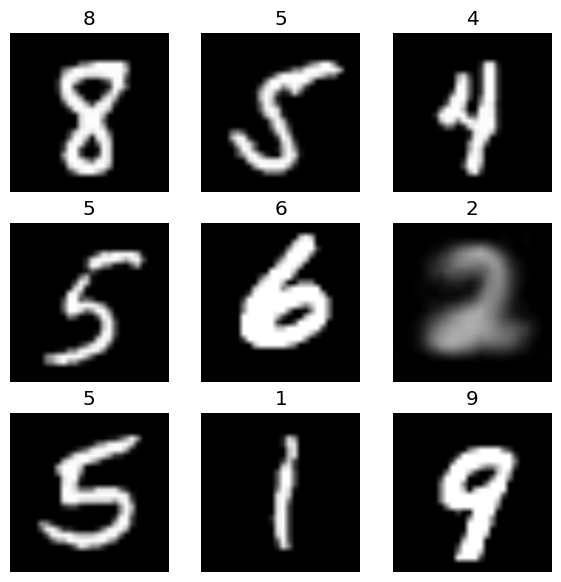

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 15: early stopping

Tiempo de entrenamiento: 523.06 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2236
Accuracy: 0.9373
Recall: 0.9367
F1-Score: 0.9369


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster03_v4.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

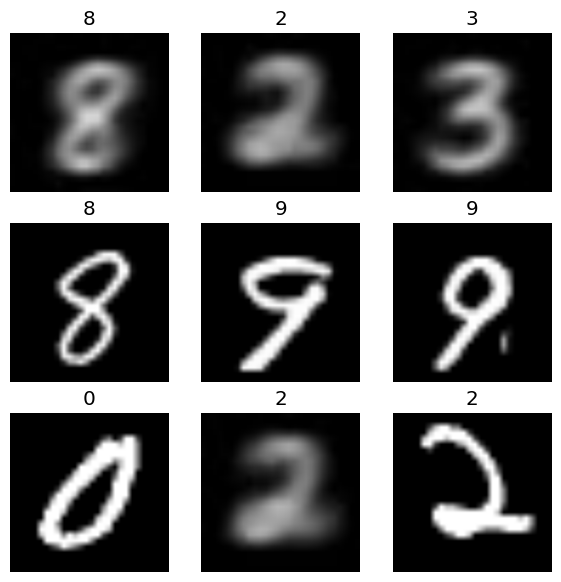

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 694
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 9: early stopping

Tiempo de entrenamiento: 360.19 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3001
Accuracy: 0.9150
Recall: 0.9136
F1-Score: 0.9140


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster01_v4.pkl')

Example 2

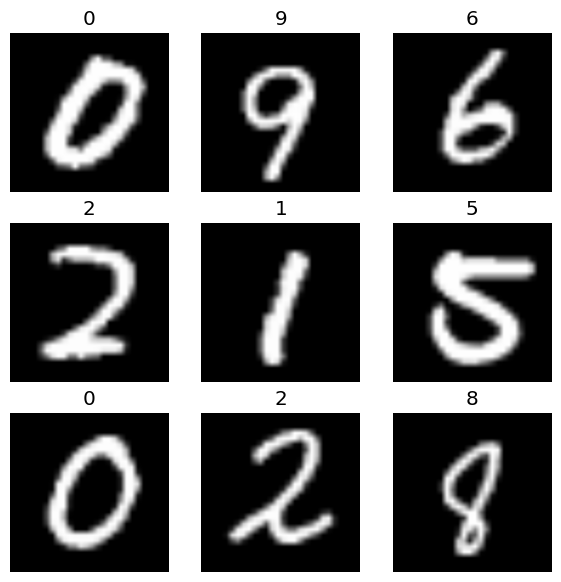

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 551.43 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2189
Accuracy: 0.9361
Recall: 0.9355
F1-Score: 0.9356


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster03_v4.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

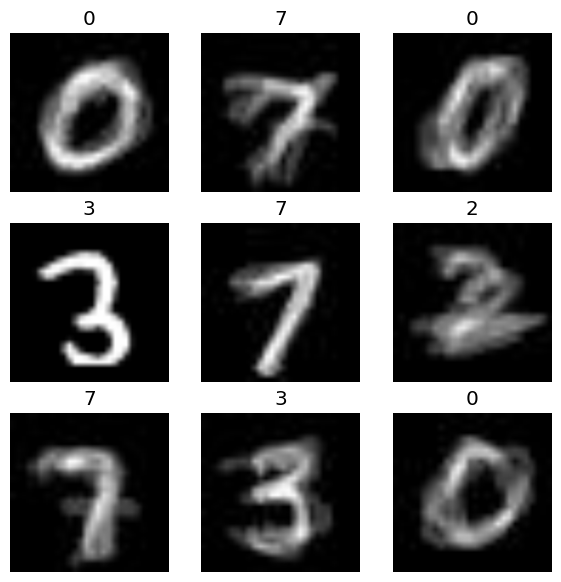

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 12101
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")


Tiempo de entrenamiento: 2776.75 segundos


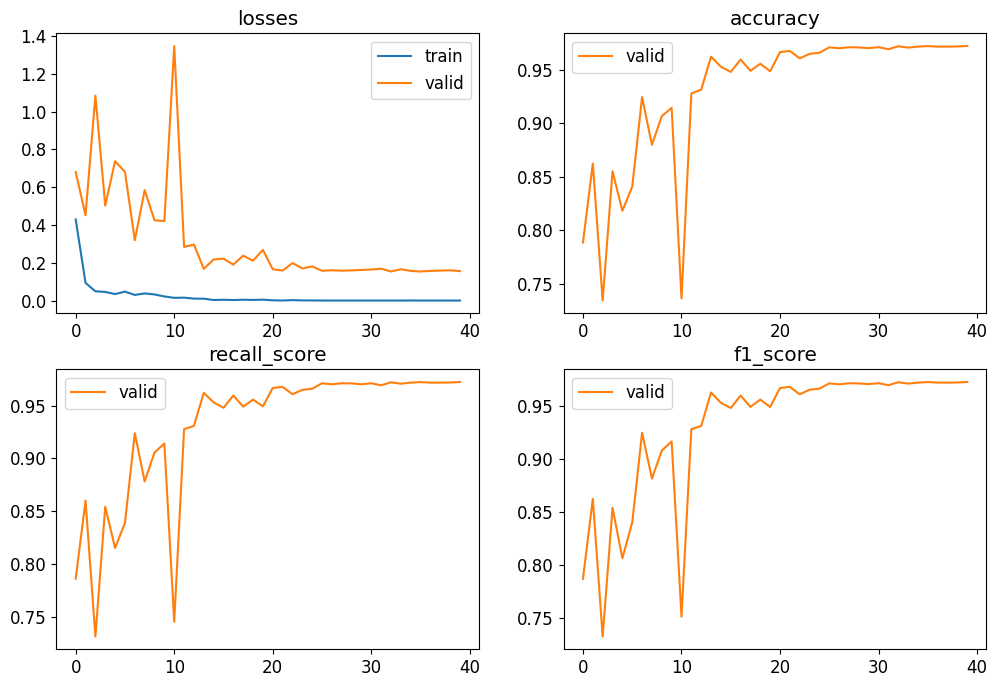

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.1557
Accuracy: 0.9723
Recall: 0.9723
F1-Score: 0.9722


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster01_v4.pkl')

Example 2

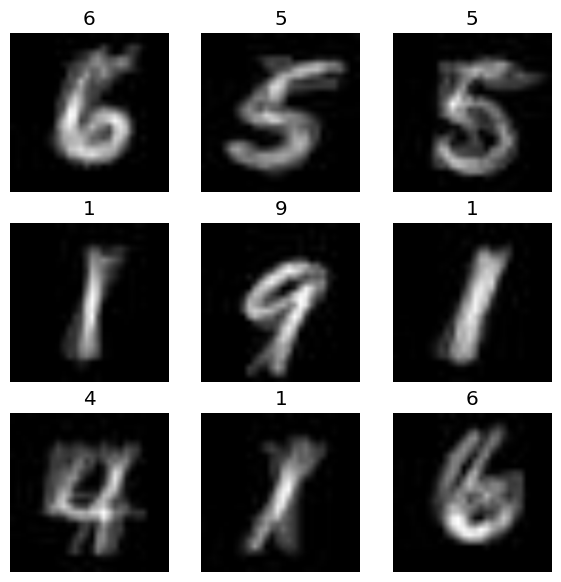

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster02_v4.pkl')

Example 3

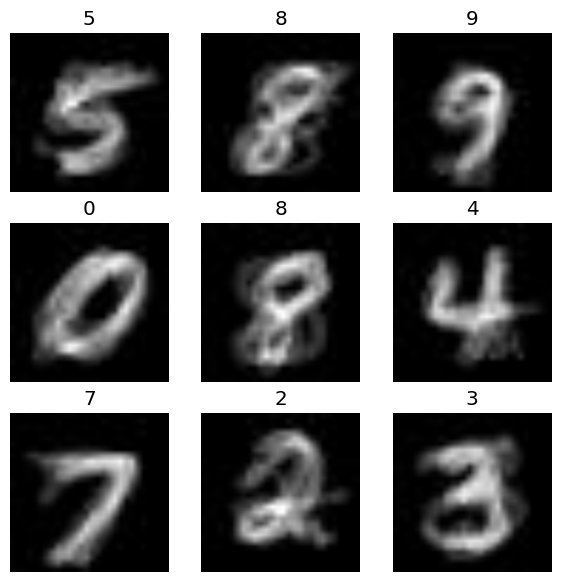

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

No improvement since epoch 17: early stopping

Tiempo de entrenamiento: 831.42 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3471
Accuracy: 0.9281
Recall: 0.9277
F1-Score: 0.9273


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster03_v3.pkl')

# TEST

In [ ]:
test_path = Path('/content/dataset/original/mnist_png/testing')

## Original - Lenet

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)


In [ ]:
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.03486732020974159
Accuracy: 0.9899839758872986
Recall (macro): 0.9898853968743563
F1 Score (macro): 0.9899635312113005


## Original - RESNET18

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    #splitter=IndexSplitter([])
    splitter=RandomSplitter(valid_pct=0.0)
)

test_dls = test_block.dataloaders(test_path)


In [ ]:
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.0206071175634861
Accuracy: 0.9947916865348816
Recall (macro): 0.994705931233183
F1 Score (macro): 0.994726425556588


# Apartado 2

## Distilled 001 & 5 cluster - Lenet


In [11]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [12]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [13]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.0712287575006485
Accuracy: 0.9787660241127014
Recall (macro): 0.9785530565207224
F1 Score (macro): 0.9786616133679159


 Distilled 001 & 5 cluster - Lenet Ex2


In [14]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [15]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.06854564696550369
Accuracy: 0.98046875
Recall (macro): 0.9803395426301333
F1 Score (macro): 0.9803923352236552


Distilled 001 & 5 cluster - Lenet Ex3


In [16]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [17]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.06454867124557495
Accuracy: 0.979567289352417
Recall (macro): 0.9794853136634105
F1 Score (macro): 0.9794354866331585


## Distilled 005 & 5 cluster - Lenet


In [18]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [19]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [20]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.05685250461101532
Accuracy: 0.9811698794364929
Recall (macro): 0.9810605917631017
F1 Score (macro): 0.9810419469727835


Distilled 005 & 5 cluster - Lenet Ex2


In [21]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [22]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.061073314398527145
Accuracy: 0.9803686141967773
Recall (macro): 0.9802551702092319
F1 Score (macro): 0.9802717041615194


Distilled 005 & 5 cluster - Lenet Ex3

In [23]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [24]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.05957482382655144
Accuracy: 0.9806690812110901
Recall (macro): 0.9805472220654293
F1 Score (macro): 0.9805699162614336


## Distilled 0001 & 5 cluster - Lenet


In [25]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [26]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [27]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.08409832417964935
Accuracy: 0.9828726053237915
Recall (macro): 0.9826841759165232
F1 Score (macro): 0.98278824973476


Distilled 0001 & 5 cluster - Lenet Ex2


In [28]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [29]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.09815036505460739
Accuracy: 0.9801682829856873
Recall (macro): 0.9801258770931035
F1 Score (macro): 0.9800476559191538


Distilled 0001 & 5 cluster - Lenet Ex3


In [30]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [31]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.07996013760566711
Accuracy: 0.9835737347602844
Recall (macro): 0.9834367418729884
F1 Score (macro): 0.9834275382835223


## Distilled 001 & 5 cluster - Resnet


In [51]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [33]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster01_v4.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [34]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.022979198023676872
Accuracy: 0.9931890964508057
Recall (macro): 0.9930653872233279
F1 Score (macro): 0.9931360883488413


 Distilled 001 & 5 cluster - Resnet Ex2


In [52]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster02_v4.pkl')


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [53]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.024592703208327293
Accuracy: 0.9931890964508057
Recall (macro): 0.9930858023835398
F1 Score (macro): 0.9931461813056164


 Distilled 001 & 5 cluster - Resnet Ex3


In [54]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster03_v4.pkl')


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [55]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.1653778851032257
Accuracy: 0.9538261294364929
Recall (macro): 0.9527931105897158
F1 Score (macro): 0.9531459163264859


## Distilled 005 & 5 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster01_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.635329484939575
Accuracy: 0.10096153616905212
Recall (macro): 0.10215834386542437
F1 Score (macro): 0.032234225883989755


Distilled 005 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster02_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.897846221923828
Accuracy: 0.08112980425357819
Recall (macro): 0.08872584896190777
F1 Score (macro): 0.031944699466864394


Distilled 005 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster04_v3.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.073541164398193
Accuracy: 0.08924278616905212
Recall (macro): 0.1
F1 Score (macro): 0.016386206896551726


## Distilled 0001 & 5 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster01_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.23194622993469238
Accuracy: 0.9521234035491943
Recall (macro): 0.9516056211288199
F1 Score (macro): 0.9516913387922582


Distilled 0001 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster02_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.35176512598991394
Accuracy: 0.9320913553237915
Recall (macro): 0.9317208552308539
F1 Score (macro): 0.9316014032716294


Distilled 0001 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster03_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.2719413936138153
Accuracy: 0.9469150900840759
Recall (macro): 0.9468111091381785
F1 Score (macro): 0.9463063433354251


# Apartado 3

## Distilled 001 & 2 cluster - Lenet


In [35]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [36]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [37]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.4669594466686249
Accuracy: 0.8884214758872986
Recall (macro): 0.8875687817681784
F1 Score (macro): 0.8870761642756596


Distilled 001 & 2 cluster - Lenet Ex 2

In [38]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [39]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.5575485229492188
Accuracy: 0.8418469429016113
Recall (macro): 0.841271914321698
F1 Score (macro): 0.8414175422664428


Distilled 001 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 005 & 2 cluster - Lenet


In [41]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [42]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [43]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.40294429659843445
Accuracy: 0.8806089758872986
Recall (macro): 0.878379961730932
F1 Score (macro): 0.8784417361851469


Distilled 005 & 2 cluster - Lenet Ex 2

In [44]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [45]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.42779234051704407
Accuracy: 0.8633813858032227
Recall (macro): 0.8615415188750198
F1 Score (macro): 0.8615308861073793


Distilled 005 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 0001 & 2 cluster - Lenet


In [46]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [47]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [48]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.5942133665084839
Accuracy: 0.9075520634651184
Recall (macro): 0.9068791510723024
F1 Score (macro): 0.905899201760478


Distilled 0001 & 2 cluster - Lenet Ex 2

In [49]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [50]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.615057647228241
Accuracy: 0.881911039352417
Recall (macro): 0.8816147630110567
F1 Score (macro): 0.8805079949225213


Distilled 0001 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 001 & 2 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster01_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 9.837576866149902
Accuracy: 0.08934295177459717
Recall (macro): 0.1
F1 Score (macro): 0.016403089371092312


Distilled 001 & 2 cluster - Resnet Ex 2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster02_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 14.636293411254883
Accuracy: 0.08914262801408768
Recall (macro): 0.1
F1 Score (macro): 0.016369321316902705


Distilled 001 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster03_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 11.66866397857666
Accuracy: 0.08914262801408768
Recall (macro): 0.1
F1 Score (macro): 0.016369321316902705


## Distilled 005 & 2 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster01_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.638726234436035
Accuracy: 0.11017628014087677
Recall (macro): 0.11099596378313517
F1 Score (macro): 0.03880158424909179


Distilled 005 & 2 cluster - Resnet Ex 2

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster02_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.5545315742492676
Accuracy: 0.08834134787321091
Recall (macro): 0.09898020749346195
F1 Score (macro): 0.01865915824806815


Distilled 005 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster03_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.3862836360931396
Accuracy: 0.08934295177459717
Recall (macro): 0.1
F1 Score (macro): 0.016403089371092312


## Distilled 0001 & 2 cluster - Resnet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster01_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.4198974668979645
Accuracy: 0.9189703464508057
Recall (macro): 0.9188079343362896
F1 Score (macro): 0.9181198590493962


Distilled 0001 & 2 cluster - Resnet Ex 2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster022_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.8366960287094116
Accuracy: 0.828125
Recall (macro): 0.8262062800553227
F1 Score (macro): 0.825445104942743


Distilled 0001 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster03_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.31677475571632385
Accuracy: 0.9328926205635071
Recall (macro): 0.9325043415278241
F1 Score (macro): 0.9320102976190917
